# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dot, Dropout, BatchNormalization, Dot, Activation, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os                                       
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
from tqdm.auto import tqdm
import faiss
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
# !pip install faiss-cpu
import faiss
import tensorflow as tf
from tqdm import tqdm

# Read Dataset

In [58]:
cust = pd.read_pickle('data/cust_selected_features.pkl')
cust.head()

,real_customer_id,customer_id,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill
0,1002085,131074,111019236,390.00,88.0,2756170.0,0.074359,1170,36.0,2292200.0,121411710,1,4.625000,Retail Large,822.0,131310108
1,1002086,131078,121411170,96.67,29.0,1319625.0,0.248276,290,23.0,1224532.0,121410370,2,10.285714,WS 2,195.0,111019236
2,1002087,131080,141217128,376.67,310.0,5849672.0,0.076991,1130,200.0,5634970.0,141011985,2,7.700000,WS 2,772.0,141117248
3,1002972,131082,141210977,807.33,808.0,20199480.0,0.037159,2422,608.0,15246884.0,141010324,2,5.142857,WS 2,1515.0,141012060
4,1003148,131086,111019236,101.67,150.0,2946548.0,0.281967,305,90.0,2848862.0,141210977,2,9.500000,WS 2,200.5,141010787


In [59]:
full_product = pd.read_pickle('data/product_extract_features.pkl')

full_product['mid'] = full_product['mid'].astype(str)
full_product['metadata'] = (
    full_product['mid_desc'].fillna('') + ' ' +
    full_product['desc1'].fillna('') + ' ' +
    full_product['desc2'].fillna('')
)

full_product.head()

,real_mid,mid,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata
0,61800,111616385,FN COLOGNE DESSERT VIOLET BTL 100ML,PERSONAL CARE,COLOGNE,COLOGNE SPRAY FRES&NATURAL BTL100ML24PCS,IDR,24.0,BOX,250911.856000,100.0,ML,1309.0,3067.0,807.754,1.850444e+08,FN COLOGNE DESSERT VIOLET BTL 100ML PERSONAL CARE COLOGNE
1,20322,131216387,SEDAAP MIE GORENG AYAM BAKAR LIMAU 89Gr,FOOD,NOODLES,NOODLE SEDAAPMIE GORENG 40PCS 91GR,IDR,40.0,BOX,114053.693750,91.0,GR,909.0,2147.0,3707.425,3.960111e+08,SEDAAP MIE GORENG AYAM BAKAR LIMAU 89Gr FOOD NOODLES
2,1061830,121616390,DAIA POWDET CLEAN&FRESH BAG 800GR NPRG,FABRIC CARE,POWDER DETERGENT,POWDET DAIA BAG 12PCS 800GR NPRG,IDR,12.0,BOX,196200.000000,800.0,GR,1620.0,3275.0,3209.186,5.940424e+08,DAIA POWDET CLEAN&FRESH BAG 800GR NPRG FABRIC CARE POWDER DETERGENT
3,1060153,121116393,SOKLIN PEMUTIH REGULAR BTL 500ML,FABRIC CARE,BLEACHING,BLEACHING SOKLIN BOTTLE 12PCS 500ML,IDR,12.0,BOX,73317.345333,500.0,ML,150.0,320.0,271.591,1.923183e+07,SOKLIN PEMUTIH REGULAR BTL 500ML FABRIC CARE BLEACHING
4,61229,141016395,ALE-ALE GUAVA CUP 180ML,BEVERAGE,CUP RTD,FOODRTD ALE-ALE CUP 200ML 24PCS,IDR,24.0,BOX,19750.000000,200.0,ML,4420.0,14615.0,189346.000,3.561182e+09,ALE-ALE GUAVA CUP 180ML BEVERAGE CUP RTD


In [9]:
order_cust = pd.read_pickle('data/order_cust.pkl')
order_cust.head()

,customer_id,sls_office_x,mid,date_id,value_bill,qty_box,real_mid,customer_group,sls_office_y,channel
0,145889,AA31,112510180,2024-12-27,25732.0,0.25,10910,WS Cosmetic,Caringin,GT
1,145909,AA31,101217695,2024-12-14,553814.0,10.00,1010512,WS 2,Caringin,GT
2,132727,AA31,131212142,2024-12-19,161700.0,2.00,20166,Retail Large,Caringin,GT
3,132727,AA31,131212142,2024-12-19,161700.0,2.00,20166,Retail,Tasikmalaya,GT
4,4373,AA31,131018985,2024-12-24,210000.0,1.00,20196,Retail Large,Caringin,GT


In [10]:
order_cust = order_cust[['customer_id', 'mid', 'date_id']]

In [11]:
order_cust.head()

,customer_id,mid,date_id
0,145889,112510180,2024-12-27
1,145909,101217695,2024-12-14
2,132727,131212142,2024-12-19
3,132727,131212142,2024-12-19
4,4373,131018985,2024-12-24


In [12]:
order_cust.shape

(6228366, 3)

In [13]:
order_cust.customer_id.nunique(), order_cust.mid.nunique()

(15367, 1139)

In [14]:
matrix = pd.read_pickle('data/matrix_interaction_customer_product.pkl')
matrix.head()

,customer_id,101017396,101018064,101018099,101018433,101019091,101110901,101111022,101111191,101111326,101111372,101111607,101111773,101112000,101112461,101117214,101117367,101118009,101118021,101119770,101119981,101210139,101210143,101210231,101210316,101210421,101210726,101210761,101210828,101211179,101211324,101211558,101211671,101211686,101211887,101211938,101211998,101212066,101212240,101212312,101212441,101216410,101216420,101216626,101216681,101216715,101216740,101216762,101216785,101217058,101217082,101217115,101217156,101217176,101217206,101217678,101217695,101217854,101218055,101218139,101218178,101218989,101218995,101219182,101219230,101219435,101219587,101219643,101219987,101410164,101410413,101410494,101410680,101410836,101411108,101411138,101411396,101411471,101411473,101411658,101412159,101412223,101412303,101412337,101412348,101412386,101412428,101416640,101416711,101416826,101416894,101416964,101417051,101417139,101417406,101417512,101417614,101417685,101417774,101417868,101418418,101418472,101418608,101418956,101419572,101419872,101419902,101510171,101517273,101517298,101517897,101518215,101518999,101519945,101610068,101610932,101611328,101617310,101618760,101711934,101716772,101717064,111010148,111010906,111011135,111011200,111011807,111012319,111012363,111016570,111016608,111017200,111017369,111017482,111017549,111017743,111017817,111017986,111018201,111018333,111018651,111018884,111018939,111019236,111019332,111019780,111019998,111310276,111310900,111311800,111319949,111410564,111410785,111411058,111411164,111411641,111411993,111412137,111412154,111412294,111412447,111416466,111416684,111416697,111416721,111417247,111417351,111417586,111417646,111417994,111418090,111418242,111418247,111418302,111418311,111418348,111418356,111418425,111418468,111418497,111418807,111418946,111419032,111419264,111419351,111419364,111419669,111419809,111419898,111419915,111419943,111510043,111510383,111510492,111510621,111510686,111510696,111510706,111510730,111510760,111510835,111510842,111510857,111510892,111510954,111511131,111511166,111511216,111511301,111511466,111511468,111511585,111511599,111511629,111511683,111511714,111511756,111511801,111511895,111511905,111511967,111512295,111512352,111512369,111512398,111512494,111516401,111516554,111516658,111516662,111516732,111516774,111516782,111516951,111516967,111517160,111517178,111517193,111517203,111517365,111517475,111517489,111517521,111517525,111517546,111517633,111517649,111517716,111517729,111517778,111517840,111517970,111518042,111518329,111518363,111518426,111518587,111518611,111518629,111518705,111518806,111518839,111518951,111519082,111519083,111519215,111519290,111519391,111519411,111519478,111519479,111519513,111519537,111519582,111519588,111519622,111519668,111519795,111519825,111519859,111519913,111519925,111610054,111610078,111610149,111610315,111610317,111610336,111610417,111610540,111610551,111610582,111610606,111610676,111610698,111610852,111610935,111610947,111610984,111611158,111611225,111611403,111611417,111611499,111611509,111611556,111611580,111612309,111612320,111612492,111616385,111616405,111616618,111616641,111616867,111617134,111617238,111617276,111617376,111617501,111617642,111617823,111617988,111618416,111618447,111618530,111618593,111618692,111618873,111618993,111619046,111619118,111619697,111619742,111710152,111717989,111811505,111811726,111910003,111910081,111910273,111910338,111910355,111910379,111910388,111910480,111910503,111910585,111910708,111910980,111911035,111911178,111911195,111911220,111911421,111911432,111911540,111911559,111911668,111911916,111911929,111911963,111912024,111912076,111912100,111912167,111912202,111912250,111912313,111912317,111912353,111912490,111916547,111916563,111916569,111916588,111916625,111916707,111917031,111917196,111917366,111917421,111917463,111917584,111917597,111917598,111917760,111917871,111917936,111917957,111917997,111918006,111918076,111918115,111918116,111918189,111918210,111918230,111918266,1119183

In [15]:
matrix.shape

(15367, 1140)

# Split Train/Val/Test

In [16]:
# Ensure correct data types for merging and processing
order_cust['customer_id'] = order_cust['customer_id'].astype(int)
order_cust['mid'] = order_cust['mid'].astype(str)
cust['customer_id'] = cust['customer_id'].astype(int)
full_product['mid'] = full_product['mid'].astype(str)

### Split by Transaction Date

In [17]:
def temporal_split(order_cust, frac_train=0.8, frac_val=0.1, frac_test=0.1):
    train_list, val_list, test_list = [], [], []

    order_cust = order_cust.sort_values(["customer_id", "date_id"])

    for cid, group in order_cust.groupby("customer_id"):
        n = len(group)
        n_train = max(1, int(n * frac_train))   # minimal 1 transaksi di train
        n_val = int(n * frac_val)

        if n_train + n_val >= n:
            n_train = max(1, n-2)
            n_val = 1

        train = group.iloc[:n_train]
        val = group.iloc[n_train:n_train+n_val]
        test = group.iloc[n_train+n_val:]

        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    train_data = pd.concat(train_list)
    val_data = pd.concat(val_list)
    test_data = pd.concat(test_list)

    return train_data, val_data, test_data


train_data, val_data, test_data = temporal_split(order_cust)

print(f"Number of users in Train set: {train_data['customer_id'].nunique()}")
print(f"Number of users in Validation set: {val_data['customer_id'].nunique()}")
print(f"Number of users in Test set: {test_data['customer_id'].nunique()}")

print(f"\nTotal transactions in Train set: {len(train_data)}")
print(f"Total transactions in Validation set: {len(val_data)}")
print(f"Total transactions in Test set: {len(test_data)}")

Number of users in Train set: 15367
Number of users in Validation set: 14976
Number of users in Test set: 15326

Total transactions in Train set: 4976513
Total transactions in Validation set: 616107
Total transactions in Test set: 635746


In [18]:
print("Total transactions:", len(train_data) + len(val_data) + len(test_data))

Total transactions: 6228366


In [14]:
print("Total unique users:", order_cust['customer_id'].nunique())
print("Total transactions:", len(order_cust))

Total unique users: 15367
Total transactions: 6228366


In [15]:
train_data.head(1)

,customer_id,mid,date_id
1698848,101,141219426,2024-10-04


# Preprocessing Fitur


### Create Interaction Data (Positive & Negative) --> Two Tower

In [ ]:
train_data['interaction'] = 1
val_data['interaction'] = 1
test_data['interaction'] = 1

train_pos = pd.merge(train_data, cust, on='customer_id')
train_pos = pd.merge(train_pos, full_product, on='mid')

val_pos = pd.merge(val_data, cust, on='customer_id')
val_pos = pd.merge(val_pos, full_product, on='mid')

test_pos = pd.merge(test_data, cust, on='customer_id')
test_pos = pd.merge(test_pos, full_product, on='mid')

bought_dict = order_cust.groupby('customer_id')['mid'].apply(set).to_dict()
all_mids = set(full_product['mid'].unique())

def make_negative_samples_fast(customer_ids, all_mids, cust, full_product, bought_dict, n_samples=2):
    np.random.seed(42)
    neg_samples = []
    for cid in customer_ids:
        bought_mids = bought_dict.get(cid, set())
        not_bought_mids = list(all_mids - bought_mids)
        if not not_bought_mids:
            continue
        samples = np.random.choice(not_bought_mids, size=min(len(not_bought_mids), n_samples), replace=False)
        for mid in samples:
            neg_samples.append({'customer_id': cid, 'mid': mid, 'interaction': 0})
    df_neg = pd.DataFrame(neg_samples)
    if not df_neg.empty:
        df_neg = df_neg.merge(cust, on='customer_id')
        df_neg = df_neg.merge(full_product, on='mid')
    return df_neg

train_neg = make_negative_samples_fast(train_data['customer_id'].unique(), all_mids, cust, full_product, bought_dict)
val_neg   = make_negative_samples_fast(val_data['customer_id'].unique(), all_mids, cust, full_product, bought_dict)
test_neg  = make_negative_samples_fast(test_data['customer_id'].unique(), all_mids, cust, full_product, bought_dict)

train_final = pd.concat([train_pos, train_neg], ignore_index=True).sample(frac=1).reset_index(drop=True)
val_final   = pd.concat([val_pos, val_neg], ignore_index=True).sample(frac=1).reset_index(drop=True)
test_final  = pd.concat([test_pos, test_neg], ignore_index=True).sample(frac=1).reset_index(drop=True)

print(f"Train: {len(train_final)}, Val: {len(val_final)}, Test: {len(test_final)}")

train_final = train_final.drop(columns=['date_id'], errors='ignore')
val_final   = val_final.drop(columns=['date_id'], errors='ignore')
test_final  = test_final.drop(columns=['date_id'], errors='ignore')

# Save ke pickle
train_final.to_pickle("train_final.pkl")
val_final.to_pickle("val_final.pkl")
test_final.to_pickle("test_final.pkl")

In [18]:
### LOAD:
train_final = pd.read_pickle("train_final.pkl")
val_final   = pd.read_pickle("val_final.pkl")
test_final  = pd.read_pickle("test_final.pkl")

In [19]:
print("Total final data:", len(train_final) + len(val_final) + len(test_final))

Total final data: 10621196


In [20]:
train_final.head(1)

,customer_id,mid,interaction,real_customer_id,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill,real_mid,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata
0,138882,131418742,1,5160366,121419739,60.0,8.0,315678.0,0.466667,180,3.834,262020.0,131211744,3,9.0,Retail Mode TO,112.0,141117248,20153,POTABEE REGULAR BBQ BEEF 15GR RENCENG,FOOD,Savory Snack,POTABEE REG BBQ BEEF 60PCS 15GR RCG,IDR,60.0,BOX,103567.8965,15.0,GR,5313.0,16721.0,26968.551,2.600318e+09,POTABEE REGULAR BBQ BEEF 15GR RENCENG FOOD Savory Snack


In [21]:
train_final[train_final["interaction"] == 0].head(1)

,customer_id,mid,interaction,real_customer_id,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill,real_mid,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata
159,10758,121410198,0,608878,141012060,62.0,21.0,234900.0,0.489247,186,7.0,230538.0,141210977,1,8.75,Retail,116.0,121411170,1060919,SOKLIN LIQUID DET SOFT BTL 1LT,FABRIC CARE,LIQUID DETERGENT,LIQDET SKL ABACT/SOFT/VIOLET BTL 1000ML,IDR,6.0,BOX,199448.946,1000.0,ML,9.0,14.0,11.501,2210732.744,SOKLIN LIQUID DET SOFT BTL 1LT FABRIC CARE LIQUID DETERGENT


In [22]:
print("Train shape:", train_final.shape)
print("Val shape:", val_final.shape)
print("Test shape:", test_final.shape)

Train shape: (8436137, 34)
Val shape: (1080038, 34)
Test shape: (1105021, 34)


## Scaling Two Tower

In [23]:
# Identify feature columns
user_numeric_cols = cust.select_dtypes(include=np.number).drop(columns=['customer_id']).columns.tolist()
user_cat_cols = cust.select_dtypes(include=['object']).drop(columns=['real_customer_id']).columns.tolist()

item_numeric_cols = full_product.select_dtypes(include=np.number).drop(columns=['real_mid']).columns.tolist()
item_cat_cols = full_product.select_dtypes(include=['object']).drop(columns=['mid', 'metadata']).columns.tolist()

In [24]:
full_product.head(1)

,real_mid,mid,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata
0,61800,111616385,FN COLOGNE DESSERT VIOLET BTL 100ML,PERSONAL CARE,COLOGNE,COLOGNE SPRAY FRES&NATURAL BTL100ML24PCS,IDR,24.0,BOX,250911.856,100.0,ML,1309.0,3067.0,807.754,1.850444e+08,FN COLOGNE DESSERT VIOLET BTL 100ML PERSONAL CARE COLOGNE


In [25]:
cust.head(1)

,real_customer_id,customer_id,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill
0,1002085,131074,111019236,390.0,88.0,2756170.0,0.074359,1170,36.0,2292200.0,121411710,1,4.625,Retail Large,822.0,131310108


In [26]:
print("User numeric cols:", user_numeric_cols)
print("User categorical cols:", user_cat_cols)
print("Item numeric cols:", item_numeric_cols)
print("Item categorical cols:", item_cat_cols)

User numeric cols: ['mean_transaction_per_month', 'top1_qtybox', 'top2_valuebill', 'avg_purchase_interval', 'total_transaction_count', 'top3_qtybox', 'top3_valuebill', 'segment_of_month_mode', 'avg_interval_qty_mid_1', 'transaction_avg_per_2month']
User categorical cols: ['top1product_valuebill', 'top3product_qtybox', 'customer_group', 'top3product_valuebill']
Item numeric cols: ['cond_price_unit', 'rate_avg', 'ukuran', 'n_cust', 'total_sales_count', 'total_qty_sold', 'total_revenue']
Item categorical cols: ['mid_desc', 'desc1', 'desc2', 'mg2_desc', 'rate_unit', 'base_uom', 'satuan']


In [27]:
cols_to_int = ['top1product_valuebill', 'top3product_qtybox', 'top3product_valuebill']
for col in cols_to_int:
    cust[col] = cust[col].astype(int)

cust['segment_of_month_mode'] = cust['segment_of_month_mode'].astype(str)

user_numeric_cols = cust.select_dtypes(include=np.number).drop(columns=['customer_id']).columns.tolist()
user_cat_cols = cust.select_dtypes(include=['object']).drop(columns=['real_customer_id']).columns.tolist()

item_numeric_cols = full_product.select_dtypes(include=np.number).drop(columns=['real_mid']).columns.tolist()
item_cat_cols = full_product.select_dtypes(include=['object']).drop(columns=['mid', 'metadata']).columns.tolist()

In [28]:
print("User numeric cols:", user_numeric_cols)
print("User categorical cols:", user_cat_cols)
print("Item numeric cols:", item_numeric_cols)
print("Item categorical cols:", item_cat_cols)

User numeric cols: ['top1product_valuebill', 'mean_transaction_per_month', 'top1_qtybox', 'top2_valuebill', 'avg_purchase_interval', 'total_transaction_count', 'top3_qtybox', 'top3_valuebill', 'top3product_qtybox', 'avg_interval_qty_mid_1', 'transaction_avg_per_2month', 'top3product_valuebill']
User categorical cols: ['segment_of_month_mode', 'customer_group']
Item numeric cols: ['cond_price_unit', 'rate_avg', 'ukuran', 'n_cust', 'total_sales_count', 'total_qty_sold', 'total_revenue']
Item categorical cols: ['mid_desc', 'desc1', 'desc2', 'mg2_desc', 'rate_unit', 'base_uom', 'satuan']


In [29]:
train_final.top1product_valuebill.info()

<class 'pandas.core.series.Series'>
RangeIndex: 8436137 entries, 0 to 8436136
Series name: top1product_valuebill
Non-Null Count    Dtype 
--------------    ----- 
8436137 non-null  object
dtypes: object(1)
memory usage: 64.4+ MB


In [30]:
# Mapping: kolom mana yang harus numeric / categorical
expected_numeric = set(user_numeric_cols + item_numeric_cols)
expected_categorical = set(user_cat_cols + item_cat_cols)

for col in train_final.columns:
    if col in expected_numeric:
        if not np.issubdtype(train_final[col].dtype, np.number):
            print(f"🔄 Fixing {col}: should be numeric, currently {train_final[col].dtype}")
            train_final[col] = pd.to_numeric(train_final[col], errors='coerce')
    elif col in expected_categorical:
        if train_final[col].dtype != 'object' and train_final[col].dtype.name != 'category':
            print(f"🔄 Fixing {col}: should be categorical, currently {train_final[col].dtype}")
            train_final[col] = train_final[col].astype(str)
    else:
        print(f"⚠️ {col} not listed in expected features")

⚠️ customer_id not listed in expected features
⚠️ mid not listed in expected features
⚠️ interaction not listed in expected features
⚠️ real_customer_id not listed in expected features
🔄 Fixing top1product_valuebill: should be numeric, currently object
🔄 Fixing top3product_qtybox: should be numeric, currently object
🔄 Fixing segment_of_month_mode: should be categorical, currently int32
🔄 Fixing top3product_valuebill: should be numeric, currently object
⚠️ real_mid not listed in expected features
⚠️ metadata not listed in expected features


In [31]:
for col in val_final.columns:
    if col in expected_numeric:
        if not np.issubdtype(val_final[col].dtype, np.number):
            print(f"🔄 Fixing {col}: should be numeric, currently {val_final[col].dtype}")
            val_final[col] = pd.to_numeric(val_final[col], errors='coerce')
    elif col in expected_categorical:
        if val_final[col].dtype != 'object' and val_final[col].dtype.name != 'category':
            print(f"🔄 Fixing {col}: should be categorical, currently {val_final[col].dtype}")
            val_final[col] = val_final[col].astype(str)
    else:
        print(f"⚠️ {col} not listed in expected features")

for col in test_final.columns:
    if col in expected_numeric:
        if not np.issubdtype(test_final[col].dtype, np.number):
            print(f"🔄 Fixing {col}: should be numeric, currently {test_final[col].dtype}")
            test_final[col] = pd.to_numeric(test_final[col], errors='coerce')
    elif col in expected_categorical:
        if test_final[col].dtype != 'object' and test_final[col].dtype.name != 'category':
            print(f"🔄 Fixing {col}: should be categorical, currently {test_final[col].dtype}")
            test_final[col] = test_final[col].astype(str)
    else:
        print(f"⚠️ {col} not listed in expected features")

⚠️ customer_id not listed in expected features
⚠️ mid not listed in expected features
⚠️ interaction not listed in expected features
⚠️ real_customer_id not listed in expected features
🔄 Fixing top1product_valuebill: should be numeric, currently object
🔄 Fixing top3product_qtybox: should be numeric, currently object
🔄 Fixing segment_of_month_mode: should be categorical, currently int32
🔄 Fixing top3product_valuebill: should be numeric, currently object
⚠️ real_mid not listed in expected features
⚠️ metadata not listed in expected features
⚠️ customer_id not listed in expected features
⚠️ mid not listed in expected features
⚠️ interaction not listed in expected features
⚠️ real_customer_id not listed in expected features
🔄 Fixing top1product_valuebill: should be numeric, currently object
🔄 Fixing top3product_qtybox: should be numeric, currently object
🔄 Fixing segment_of_month_mode: should be categorical, currently int32
🔄 Fixing top3product_valuebill: should be numeric, currently objec

In [32]:
not_touched_cols = ["customer_id", "mid", "interaction", "metadata"]

In [33]:
train_final.drop(columns=['real_customer_id', 'real_mid'], errors='ignore', inplace=True)
val_final.drop(columns=['real_customer_id', 'real_mid'], errors='ignore', inplace=True)
test_final.drop(columns=['real_customer_id', 'real_mid'], errors='ignore', inplace=True)

### Handling NaNs

In [34]:
num_fill_user = train_final[user_numeric_cols].median(numeric_only=True)
num_fill_item = train_final[item_numeric_cols].median(numeric_only=True)

train_final.loc[:, user_numeric_cols] = train_final[user_numeric_cols].fillna(num_fill_user)
val_final.loc[:, user_numeric_cols] = val_final[user_numeric_cols].fillna(num_fill_user)
test_final.loc[:, user_numeric_cols] = test_final[user_numeric_cols].fillna(num_fill_user)

train_final.loc[:, item_numeric_cols] = train_final[item_numeric_cols].fillna(num_fill_item)
val_final.loc[:, item_numeric_cols] = val_final[item_numeric_cols].fillna(num_fill_item)
test_final.loc[:, item_numeric_cols] = test_final[item_numeric_cols].fillna(num_fill_item)

In [36]:
train_final.head(1) #BEFORE SCALING

,customer_id,mid,interaction,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata
0,138882,131418742,1,121419739,60.0,8.0,315678.0,0.466667,180,3.834,262020.0,131211744,3,9.0,Retail Mode TO,112.0,141117248,POTABEE REGULAR BBQ BEEF 15GR RENCENG,FOOD,Savory Snack,POTABEE REG BBQ BEEF 60PCS 15GR RCG,IDR,60.0,BOX,103567.8965,15.0,GR,5313.0,16721.0,26968.551,2.600318e+09,POTABEE REGULAR BBQ BEEF 15GR RENCENG FOOD Savory Snack


### Numerical Scaling
- Dari sisi product, boleh di fit transform semua (karena product biasanya statis dan udah fix gitu aja jadi ga mungkin data leakage) 

- Dari sisi user itu fit doang di train, sisanya transform (anggepannya user baru)

In [37]:
scaler_user = StandardScaler()
train_final.loc[:, user_numeric_cols] = scaler_user.fit_transform(train_final[user_numeric_cols])
# For validation and test data, new customer features are transformed using the training scaler
val_final.loc[:, user_numeric_cols] = scaler_user.transform(val_final[user_numeric_cols])
test_final.loc[:, user_numeric_cols] = scaler_user.transform(test_final[user_numeric_cols])

scaler_item = StandardScaler()
# Fit item scaler on the entire dataset to capture the full range of product features
all_item_data = pd.concat([train_final[item_numeric_cols], val_final[item_numeric_cols], test_final[item_numeric_cols]], ignore_index=True)
scaler_item.fit(all_item_data)
train_final.loc[:, item_numeric_cols] = scaler_item.transform(train_final[item_numeric_cols])
val_final.loc[:, item_numeric_cols] = scaler_item.transform(val_final[item_numeric_cols])
test_final.loc[:, item_numeric_cols] = scaler_item.transform(test_final[item_numeric_cols])

In [38]:
train_final.head(1) #AFTER SCALING

,customer_id,mid,interaction,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata
0,138882,131418742,1,-0.979876,-0.681711,-0.238831,-0.254505,0.074565,-0.680974,-0.289029,-0.288308,-0.093498,3,0.049673,Retail Mode TO,-0.683387,0.948161,POTABEE REGULAR BBQ BEEF 15GR RENCENG,FOOD,Savory Snack,POTABEE REG BBQ BEEF 60PCS 15GR RCG,IDR,-0.311599,BOX,-0.169349,-0.38391,GR,-0.196249,-0.415457,-0.343639,-0.383477,POTABEE REGULAR BBQ BEEF 15GR RENCENG FOOD Savory Snack


### Feature Encoding
Label Encoding for User ID & Item ID

In [39]:
# Fill -1 buat unseen labels
def safe_label_transform(le, series, fill_value=-1):
    """Transforms a series using a fitted LabelEncoder, handling unseen labels."""
    known_classes = {cls: i for i, cls in enumerate(le.classes_)}
    return series.apply(lambda x: known_classes.get(x, fill_value))

# Fit user IDs only on training data (simulating new users)
user_le = LabelEncoder().fit(train_final['customer_id'])
print(f"Unique users in training: {len(user_le.classes_)}")
train_final['customer_id_encoded'] = user_le.transform(train_final['customer_id'])
val_final['customer_id_encoded'] = safe_label_transform(user_le, val_final['customer_id'])
test_final['customer_id_encoded'] = safe_label_transform(user_le, test_final['customer_id'])
print("✅ User ID encoding complete (customer features are from training only).")

# Fit item IDs on the entire dataset
item_le = LabelEncoder().fit(pd.concat([train_final['mid'], val_final['mid'], test_final['mid']]))
print(f"Unique items in all data: {len(item_le.classes_)}")
train_final['mid_encoded'] = item_le.transform(train_final['mid'])
val_final['mid_encoded'] = item_le.transform(val_final['mid'])
test_final['mid_encoded'] = item_le.transform(test_final['mid'])
print("✅ Product ID encoding complete (product features are from all data).")

Unique users in training: 15367
✅ User ID encoding complete (customer features are from training only).
Unique items in all data: 1561
✅ Product ID encoding complete (product features are from all data).


In [40]:
(test_final['customer_id_encoded'] == -1).sum()

0

Gada user yang unseen during training. Jadi aman ga ada cold start

In [41]:
users_train = set(train_final['customer_id'])
users_test_only = set(test_final['customer_id']) - users_train
print("Users hanya di test:", users_test_only)

Users hanya di test: set()


In [42]:
print("Len users only in test:", len(users_test_only))

Len users only in test: 0


In [43]:
train_final.shape

(8436137, 34)

Label Encoding for All Categorical Features

In [44]:
print("\nEncoding categorical features...")
cat_encoders = {}
for col in tqdm(user_cat_cols + item_cat_cols, desc="Processing categorical columns"):
    # Fix: Ensure the column data is uniformly a string before fitting the encoder.
    # .astype(str) will convert both numbers and NaNs (after fillna) to strings.
    
    # User categorical features: Fit on training data only
    if col in user_cat_cols:
        le = LabelEncoder().fit(train_final[col].fillna('').astype(str))
        cat_encoders[col] = le
        train_final.loc[:, col] = le.transform(train_final[col].fillna('').astype(str))
        val_final.loc[:, col] = safe_label_transform(le, val_final[col].fillna('').astype(str))
        test_final.loc[:, col] = safe_label_transform(le, test_final[col].fillna('').astype(str))
    
    # Item categorical features: Fit on all data
    elif col in item_cat_cols:
        le = LabelEncoder().fit(pd.concat([train_final[col], val_final[col], test_final[col]]).fillna('').astype(str))
        cat_encoders[col] = le
        train_final.loc[:, col] = le.transform(train_final[col].fillna('').astype(str))
        val_final.loc[:, col] = le.transform(val_final[col].fillna('').astype(str))
        test_final.loc[:, col] = le.transform(test_final[col].fillna('').astype(str))


n_users = len(user_le.classes_)
n_items = len(item_le.classes_)

print("✅ Categorical encoding complete.")
print(f"\nUsers: {n_users} | Items: {n_items}")
print(f"Train: {train_final.shape}, Val: {val_final.shape}, Test: {len(test_final.customer_id.unique())} users")


Encoding categorical features...


Processing categorical columns: 100%|██████████| 9/9 [00:19<00:00,  2.21s/it]

✅ Categorical encoding complete.

Users: 15367 | Items: 1561
Train: (8436137, 34), Val: (1080038, 34), Test: 15326 users


In [45]:
display(train_final.head(1))
display(val_final.head(1))
display(test_final.head(1))

,customer_id,mid,interaction,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata,customer_id_encoded,mid_encoded
0,138882,131418742,1,-0.979876,-0.681711,-0.238831,-0.254505,0.074565,-0.680974,-0.289029,-0.288308,-0.093498,2,0.049673,22,-0.683387,0.948161,905,2,40,360,0,-0.311599,0,-0.169349,-0.38391,0,-0.196249,-0.415457,-0.343639,-0.383477,POTABEE REGULAR BBQ BEEF 15GR RENCENG FOOD Savory Snack,12239,1375


,customer_id,mid,interaction,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata,customer_id_encoded,mid_encoded
0,7151,121411170,1,0.778889,-0.094478,0.210627,0.005291,-0.058237,-0.093868,0.134482,-0.046494,0.678221,2,-0.31812,29,-0.111377,0.956097,1224,1,26,284,0,0.267591,0,-0.291623,-0.368106,1,1.024721,1.682514,0.429528,0.529382,SOKLIN LIQUID DET KOREAN CAM SCT 20ML FABRIC CARE LIQUID DETERGENT,4157,882


,customer_id,mid,interaction,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata,customer_id_encoded,mid_encoded
0,1986,121710834,1,-1.91351,-0.2511,-0.157857,-0.06516,-0.052276,-0.250458,-0.164973,-0.025126,-0.092872,1,-0.101994,28,-0.224765,0.110151,1002,1,38,426,0,1.889323,0,-0.166041,-0.390232,1,0.49595,0.477741,-0.282923,-0.176441,ROYALE SOFT HIJAB BLUESAPPHIRE 13ML 4R1P FABRIC CARE SOFTENER,1088,1160


# EVALUATION METRICS (FOR ALL)

In [46]:
def precision_at_k(actual_set, predicted_unique_set):
    if not actual_set or not predicted_unique_set:
        return 0.0
    hits_set = actual_set & predicted_unique_set
    denominator = len(predicted_unique_set)
    return len(hits_set) / float(denominator)

def recall_at_k(actual, predicted, k=10):
    if not actual: return 0.0
    pred_k = predicted[:k]
    return len(set(pred_k) & set(actual)) / float(len(set(actual)))

def average_precision(actual, predicted, k=10):
    if not actual: return 0.0
    pred_k = predicted[:k]
    score, hits = 0.0, 0
    actual_set = set(actual)
    for i, p in enumerate(pred_k, start=1):
        if p in actual_set:
            hits += 1
            score += hits / i
    return score / min(len(actual_set), k)

def ndcg_at_k(actual, predicted, k=10):
    pred_k = predicted[:k]
    if not actual: return 0.0
    actual_set = set(actual)
    dcg = 0.0
    for i, p in enumerate(pred_k, start=1):
        if p in actual_set:
            dcg += 1.0 / np.log2(i + 1)
    ideal_hits = min(len(actual_set), k)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1))
    return dcg / idcg if idcg > 0 else 0.0

# --- Helper Dictionary ---
if 'mid_to_desc2_map' not in locals():
     full_product['desc2'] = full_product['desc2'].fillna('UNKNOWN_CATEGORY')
     mid_to_desc2_map = pd.Series(
         full_product['desc2'].values, 
         index=full_product['mid'].astype(str)
     ).to_dict()

# Content Based Filtering
Using the TF-IDF and Cosine Similarity.
Recommends items that are similar in content to items a user has liked in the past.

In [46]:
full_product.head(1)

,real_mid,mid,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue,metadata
0,61800,111616385,FN COLOGNE DESSERT VIOLET BTL 100ML,PERSONAL CARE,COLOGNE,COLOGNE SPRAY FRES&NATURAL BTL100ML24PCS,IDR,24.0,BOX,250911.856,100.0,ML,1309.0,3067.0,807.754,1.850444e+08,FN COLOGNE DESSERT VIOLET BTL 100ML PERSONAL CARE COLOGNE


In [47]:
full_product['metadata'].head(1)

0    FN COLOGNE DESSERT VIOLET BTL 100ML PERSONAL CARE COLOGNE
Name: metadata, dtype: object

In [48]:
# Concatenates product description fields into a single string for each product
full_product['mid'] = full_product['mid'].astype(str)

In [49]:
# Converts the metadata into a TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(full_product['metadata'])
# Computes pairwise similarity between all products
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# Maps product IDs (mid) to their DataFrame index for quick lookup
product_indices = pd.Series(full_product.index, index=full_product['mid']).drop_duplicates()

### (Analysis) - AVG-MEDIAN Unique Item per Cust

In [50]:
print(len(order_cust))
print(len(train_final))
print(len(val_final))
print(len(test_final))

6228366
8436137
1080038
1105021


In [51]:
# --- Statistik Keseluruhan (dari 'order_cust' asli) ---
# order_cust hanya berisi pembelian aktual, jadi tidak perlu filter
overall_unique_items_per_cust = order_cust.groupby('customer_id')['mid'].nunique()

# --- Statistik Train Set ---
# Kita HANYA hitung transaksi positif (yang benar-benar dibeli)
train_positive = train_final[train_final['interaction'] != 0]
train_unique_items_per_cust = train_positive.groupby('customer_id')['mid'].nunique()

# --- Statistik Validation Set ---
val_positive = val_final[val_final['interaction'] != 0]
val_unique_items_per_cust = val_positive.groupby('customer_id')['mid'].nunique()

# --- Statistik Test Set ---
test_positive = test_final[test_final['interaction'] != 0]
test_unique_items_per_cust = test_positive.groupby('customer_id')['mid'].nunique()

results = {
    "Overall": {
        "Rata-rata": overall_unique_items_per_cust.mean(),
        "Median": overall_unique_items_per_cust.median()
    },
    "Train Set": {
        "Rata-rata": train_unique_items_per_cust.mean(),
        "Median": train_unique_items_per_cust.median()
    },
    "Validation Set": {
        "Rata-rata": val_unique_items_per_cust.mean(),
        "Median": val_unique_items_per_cust.median()
    },
    "Test Set": {
        "Rata-rata": test_unique_items_per_cust.mean(),
        "Median": test_unique_items_per_cust.median()
    }
}

results_df = pd.DataFrame(results).T.applymap('{:,.2f}'.format)
print("Statistik Jumlah Unique Item per Pelanggan (Hanya Transaksi Positif)")
display(results_df)

Statistik Jumlah Unique Item per Pelanggan (Hanya Transaksi Positif)


,Rata-rata,Median
Overall,122.50,102.00
Train Set,109.65,89.00
Validation Set,26.67,17.00
Test Set,27.11,18.00


### (Analysis) - Cosine Similarity Score (Without MMR)

In [52]:
# For a given product, finds the most similar products (excluding itself) and returns their IDs
def get_content_recommendations(product_mid, n_recs=10):
    product_mid = str(product_mid)
    if product_mid not in product_indices: return [] #KELUARIN COSINE SIMILARITY
    idx = product_indices[product_mid]
    sim_scores = sorted(list(enumerate(cosine_sim[idx])), key=lambda x: x[1], reverse=True)[1:n_recs+1]
    product_indices_rec = [i[0] for i in sim_scores]
    return full_product['mid'].iloc[product_indices_rec].tolist()

# Using last purchase
def content_wrapper(cid, n_recs=10):
    # user_purchases = test_final[test_final['customer_id'] == cid]
    user_purchases = test_final[(test_final['customer_id'] == cid) & (test_final['interaction'] != 0)]
    if user_purchases.empty: return []
    last_mid = user_purchases.iloc[-1]['mid']
    try:
        return get_content_recommendations(last_mid, n_recs)
    except Exception:
        return []

In [54]:
def analyze_similarity(product_mid, n_top=30):
    """
    Menganalisis dan menampilkan Top N produk yang paling mirip
    dengan satu produk acuan, beserta skor cosine similarity-nya.
    """
    product_mid = str(product_mid)
    
    # 1. Pastikan produk acuan ada di dalam indeks
    if product_mid not in product_indices:
        print(f"Error: Product MID '{product_mid}' tidak ditemukan di dalam product_indices.")
        return

    # 2. Dapatkan informasi produk acuan untuk perbandingan
    input_product_info = full_product[full_product['mid'] == product_mid].iloc[0]
    
    print("--- 🎯 PRODUK ACUAN ---")
    print(f"MID: {input_product_info['mid']}")
    print(f"Deskripsi: {input_product_info['mid_desc']}")
    print(f"Metadata: {input_product_info['metadata']}")
    print("------------------------\n")
    
    # 3. Ambil vektor skor kemiripan untuk produk ini
    idx = product_indices[product_mid]
    all_scores_list = list(enumerate(cosine_sim[idx]))

    # 4. Buat DataFrame dari skor tersebut
    # Kita berikan nama '_index' agar bisa di-merge dengan indeks full_product
    scores_df = pd.DataFrame(all_scores_list, columns=['_index', 'similarity_score'])
    
    # 5. Gabungkan dengan data produk untuk mendapatkan deskripsi
    # Kita merge 'scores_df' (berdasarkan '_index') dengan 'full_product' (berdasarkan index-nya)
    analysis_df = full_product.merge(scores_df, left_index=True, right_on='_index')
    
    # 6. Urutkan berdasarkan skor, dari tertinggi ke terendah
    analysis_df = analysis_df.sort_values(by='similarity_score', ascending=False)
    
    # 7. Ambil Top N (kita buang baris pertama, karena itu adalah produk itu sendiri)
    top_matches = analysis_df.iloc[1:n_top+1]
    
    print(f"--- 📊 TOP {n_top} PRODUK PALING MIRIP ---")
    
    # Tampilkan kolom-kolom penting
    display_cols = ['mid', 'mid_desc', 'similarity_score', 'metadata']
    display(top_matches[display_cols].reset_index(drop=True))
    
    return top_matches

In [55]:
sample_user_id = test_final['customer_id'].sample(1, random_state=42).iloc[0]
user_purchases = test_final[(test_final['customer_id'] == sample_user_id) & (test_final['interaction'] != 0)]
product_id_to_analyze = user_purchases.iloc[-1]['mid']

top_30_similar = analyze_similarity(product_id_to_analyze, n_top=30)

--- 🎯 PRODUK ACUAN ---
MID: 141016395
Deskripsi: ALE-ALE GUAVA CUP 180ML
Metadata: ALE-ALE GUAVA CUP 180ML BEVERAGE CUP RTD
------------------------

--- 📊 TOP 30 PRODUK PALING MIRIP ---


,mid,mid_desc,similarity_score,metadata
0,141010787,ALE-ALE ORANGE CUP 180ML,0.883026,ALE-ALE ORANGE CUP 180ML BEVERAGE CUP RTD
1,141018524,ALE-ALE STRAWBERRY CUP 180ML,0.878674,ALE-ALE STRAWBERRY CUP 180ML BEVERAGE CUP RTD
2,141016818,ALE-ALE SIRSAK CUP 180ML,0.855572,ALE-ALE SIRSAK CUP 180ML BEVERAGE CUP RTD
3,141012221,ALE ALE LECI CUP 180ML,0.855572,ALE ALE LECI CUP 180ML BEVERAGE CUP RTD
4,141017038,ALE-ALE GRAPE CUP 180ML,0.855572,ALE-ALE GRAPE CUP 180ML BEVERAGE CUP RTD
5,141011388,ALE-ALE MARKISA CUP 180ML,0.843381,ALE-ALE MARKISA CUP 180ML BEVERAGE CUP RTD
6,141019856,ALE ALE COCOPANDAN CUP 180 ML,0.709826,ALE ALE COCOPANDAN CUP 180 ML BEVERAGE CUP RTD
7,141011985,ALE ALE MANGGA CUP 180 ML,0.709826,ALE ALE MANGGA CUP 180 ML BEVERAGE CUP RTD
8,141016857,TEH RIO MANIS CUP 180ML,0.489529,TEH RIO MANIS CUP 180ML BEVERAGE CUP RTD
9,141016738,TEH RIO MADU CUP 180ML,0.468944,TEH RIO MADU CUP 180ML BEVERAGE CUP RTD


## Tuning MMR (Maximal Marginal Relevance)

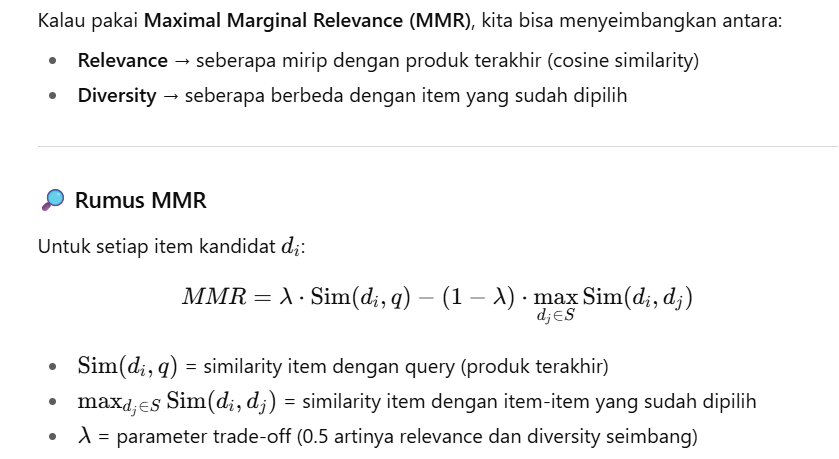

In [56]:
def mmr(query_idx, cosine_sim, lambda_param=0.5, top_n=10):
    # Get all possible candidates (all items)
    candidates = list(range(cosine_sim.shape[0]))
    # Remove the query item itself from the candidates
    candidates.remove(query_idx)

    # Get the similarity scores of all items *to the query item*
    sim_query = cosine_sim[query_idx]
    
    # This list will hold our final top_n recommended item indices
    selected = []
    
    # Loop until we have selected top_n items or run out of candidates
    while len(selected) < top_n and candidates:
        scores = []
        # Iterate through all remaining candidates
        for idx in candidates:
            # 1. Calculate Relevance: Similarity to the original query
            relevance = sim_query[idx]
            
            # 2. Calculate Diversity: Similarity to items *already selected*
            if selected:
                # Find the *maximum* similarity to any item already in our 'selected' list
                # High diversity score = low diversity (it's redundant)
                diversity = max(cosine_sim[idx][j] for j in selected)
            else:
                # No items selected yet, so diversity penalty is 0
                diversity = 0
                
            # 3. Calculate MMR Score: Balance relevance and diversity
            # lambda_param controls the trade-off (0.5 = equal balance)
            mmr_score = lambda_param * relevance - (1 - lambda_param) * diversity
            scores.append((idx, mmr_score))
            
        # Find the candidate with the highest MMR score
        best_idx, _ = max(scores, key=lambda x: x[1])
        # Add the best item to our selected list
        selected.append(best_idx)
        # Remove the selected item from future consideration
        candidates.remove(best_idx)
    
    return selected

In [57]:
# Core function: Generates recommendations for a single product
def get_content_recommendations(product_mid, n_recs=10, lambda_param=0.5):
    
    # Ensure the product ID is a string, as our lookup index uses strings.
    product_mid = str(product_mid)
    
    # Check if the product exists in our lookup map (product_indices).
    if product_mid not in product_indices:
        # If not found (e.g., new or bad ID), return an empty list.
        return []
        
    # Get the integer index (row/column number) of the product from the cosine_sim matrix.
    idx = product_indices[product_mid]

    # Call the MMR function to get the list of diverse & relevant item indices.
    # This is where the complex logic (balancing relevance vs. diversity) happens.
    selected_indices = mmr(idx, cosine_sim, lambda_param=lambda_param, top_n=n_recs)
    
    # Convert the list of integer indices back to the original product IDs ('mid').
    return full_product['mid'].iloc[selected_indices].tolist()

In [58]:
# Using last purchase
def content_wrapper(cid, n_recs=10):
    # user_purchases = test_final[test_final['customer_id'] == cid]
    user_purchases = test_final[(test_final['customer_id'] == cid) & (test_final['interaction'] != 0)]
    if user_purchases.empty: return []
    last_mid = user_purchases.iloc[-1]['mid']
    try:
        return get_content_recommendations(last_mid, n_recs)
    except Exception:
        return []

### Evaluation

In [ ]:
def evaluate_anchor_by_mid(core_model_func, data, product_indices, n_samples=3, k=10):
    """
    Evaluator for the 3-sample anchor scenario, measuring 'mid' relevance.
    Metrics: Flexible Precision, Recall, MAP, NDCG, Coverage.
    """
    all_precisions, all_recalls, all_maps, all_ndcgs = [], [], [], []
    all_recommended_mids = set() # For coverage

    unique_users = data['customer_id'].unique()
    for cid in tqdm(unique_users, desc="Evaluating Anchor (by mid)"):
        
        user_purchases_df = data[(data['customer_id'] == cid) & (data['interaction'] != 0)]
        if user_purchases_df.empty: continue
        
        all_purchased_mids_set = set(user_purchases_df['mid']) 

        n_to_sample = min(n_samples, len(user_purchases_df))
        if n_to_sample == 0: continue
        anchor_products = user_purchases_df.sample(n_to_sample)
        
        for _, row in anchor_products.iterrows():
            anchor_mid = row['mid']
            
            # Target: Semua item lain di keranjang
            actual_set = all_purchased_mids_set - {anchor_mid} 
            
            if not actual_set:      
                continue

            predicted_mids = core_model_func(anchor_mid, n_recs=k)
            if not predicted_mids:
                all_precisions.append(0.0); all_recalls.append(0.0); all_maps.append(0.0); all_ndcgs.append(0.0)
                continue
                
            all_recommended_mids.update(predicted_mids)
            
            # --- PEMANGGILAN METRIK (YANG TADI ERROR) ---
            # Kita siapkan set untuk precision fleksibel Anda
            predicted_set = set(predicted_mids)
            
            all_precisions.append(precision_at_k(actual_set, predicted_set))
            all_maps.append(average_precision(actual_set, predicted_mids, k))
            all_ndcgs.append(ndcg_at_k(actual_set, predicted_mids, k))

    # --- Calculate Final Metrics ---
    mean_precision = np.mean(all_precisions) if all_precisions else 0.0
    mean_map = np.mean(all_maps) if all_maps else 0.0
    mean_ndcg = np.mean(all_ndcgs) if all_ndcgs else 0.0
    
    total_products_in_catalog = len(product_indices)
    catalog_coverage = len(all_recommended_mids) / float(total_products_in_catalog)
    
    return {
        "Precision@K": mean_precision,
        "MAP@K": mean_map,
        "NDCG@K": mean_ndcg,
        "Catalog Coverage": catalog_coverage
    }

In [67]:
mid_relevance_metrics = evaluate_anchor_by_mid(
    get_content_recommendations,
    test_final, 
    product_indices, 
    n_samples=3,
    k=10
)
print("\n" + "="*50)
print("CONTENT-BASED (MMR) EVALUATION (by 'mid')")
print("="*50)
print(pd.DataFrame([mid_relevance_metrics], index=['Content_MMR']).T)

Evaluating Anchor (by mid): 100%|██████████| 15326/15326 [20:25<00:00, 12.51it/s]


CONTENT-BASED (MMR) EVALUATION (by 'mid')
                  Content_MMR
Precision@K          0.053899
MAP@K                0.032057
NDCG@K               0.072824
Catalog Coverage     0.887892


### Inference

In [74]:
sample_user_id = 9882
print(f"Menjalankan inference (MMR) untuk Customer ID: {sample_user_id}")

# Cari tahu produk apa yang terakhir kali ia beli (hanya yang interaction != 0)
user_purchases = test_final[(test_final['customer_id'] == sample_user_id) & (test_final['interaction'] != 0)]

if not user_purchases.empty:
    # Ambil ID produk dari pembelian terakhir
    last_purchase_mid = user_purchases.iloc[-1]['mid']
    
    # Dapatkan info produk tersebut untuk konteks
    last_purchase_info = full_product[full_product['mid'] == last_purchase_mid]
    print(f"\n💡 Berdasarkan pembelian terakhir: '{last_purchase_info['mid_desc'].iloc[0]}'")

    # --- PERBAIKAN: Panggil dengan lambda_param EKSPLISIT ---
    # Gunakan 0.5 untuk keseimbangan, atau turunkan ke 0.3 jika ingin lebih beragam
    recommended_mids = get_content_recommendations(last_purchase_mid, n_recs=10, lambda_param=0.5)

    # Tampilkan hasilnya
    if recommended_mids:
        recommendations_df = pd.DataFrame({'mid': recommended_mids})
        recommendations_df = recommendations_df.merge(
            full_product[['mid', 'mid_desc', 'desc1']], 
            on='mid', 
            how='left'
        )
        print("\n✅ Berikut adalah Top 10 Produk (MMR Balanced):")
        display(recommendations_df)
    else:
        print("Tidak ada rekomendasi yang bisa dibuat berdasarkan produk ini.")
else:
    print(f"Tidak ditemukan riwayat pembelian untuk Customer ID {sample_user_id} di data tes.")

Menjalankan inference (MMR) untuk Customer ID: 9882

💡 Berdasarkan pembelian terakhir: 'SO SOFT LIQDET SWT PNY DBL SCT 80ML R8'

✅ Berikut adalah Top 10 Produk (MMR Balanced):


,mid,mid_desc,desc1
0,121411373,SO SOFT LIQDET SAKURA DBL SCT 80ML R8,FABRIC CARE
1,121419971,SO SOFT LIQDET SWEET PNY BTL 700ML (P),FABRIC CARE
2,131216387,SEDAAP MIE GORENG AYAM BAKAR LIMAU 89Gr,FOOD
3,141016395,ALE-ALE GUAVA CUP 180ML,BEVERAGE
4,101416711,FLOORCLNER SOKLIN LGRASS POUCH 770ML,HOUSE HOLD
5,111311424,KODOMO WET WIPES HAND AND MOUTH 50S B1G1,PERSONAL CARE
6,121810594,WIZZ STAIN REMOVER PCH 425ML,FABRIC CARE
7,111919486,ZINC SHAMPOO A.KETOMBE REFRESH JRG 25KG,PERSONAL CARE
8,121710569,SOKLIN SOFTENER 1X BLS FINE&CFT PCH650ML,FABRIC CARE
9,141311045,SEGAR DINGIN JERUK NIPIS SCT 7G CANISTER,BEVERAGE


### (Analysis) Cosine Similarity Score (Using MMR)

In [71]:
def analyze_mmr_similarity(product_mid, n_recs=10, lambda_param=0.5):
    """
    Menganalisis rekomendasi MMR langkah demi langkah.
    Menampilkan Skor MMR, Skor Relevansi (Kemiripan dengan Induk), 
    dan Skor Diversity (Kemiripan dengan item yang sudah terpilih).
    """
    product_mid = str(product_mid)
    
    # 1. Validasi Produk
    if product_mid not in product_indices:
        print(f"Error: Product MID '{product_mid}' tidak ditemukan.")
        return

    # Dapatkan info produk acuan
    idx = product_indices[product_mid]
    product_info = full_product.iloc[idx]
    
    print(f"--- 🎯 PRODUK ACUAN (Lambda={lambda_param}) ---")
    print(f"MID: {product_info['mid']}")
    print(f"Desc: {product_info['mid_desc']}")
    print(f"Metadata: {product_info['metadata']}")
    print("-" * 60)

    # 2. Persiapan MMR
    candidates = list(range(cosine_sim.shape[0]))
    candidates.remove(idx) # Hapus produk acuan dari kandidat
    
    # Skor kemiripan semua item terhadap produk acuan (Relevance)
    sim_query = cosine_sim[idx]
    
    selected_indices = []
    analysis_data = []

    # 3. Loop Seleksi MMR
    # Kita lakukan iterasi sebanyak 'n_recs'
    for step in range(n_recs):
        best_score = -float('inf')
        best_candidate_idx = -1
        best_relevance = 0
        best_diversity_penalty = 0
        
        # Cek setiap kandidat yang tersisa
        for curr_idx in candidates:
            # A. Hitung Relevansi (Kemiripan dengan Acuan)
            relevance = sim_query[curr_idx]
            
            # B. Hitung Diversity Penalty (Kemiripan dengan Item yang SUDAH dipilih)
            if selected_indices:
                # Cari kemiripan TERTINGGI dengan item yang sudah ada di list rekomendasi
                diversity_penalty = max(cosine_sim[curr_idx][selected_idx] for selected_idx in selected_indices)
            else:
                diversity_penalty = 0
            
            # C. Hitung Skor MMR
            # Rumus: (Lambda * Relevansi) - ((1-Lambda) * Diversity Penalty)
            mmr_score = (lambda_param * relevance) - ((1 - lambda_param) * diversity_penalty)
            
            # Cari skor tertinggi ronde ini
            if mmr_score > best_score:
                best_score = mmr_score
                best_candidate_idx = curr_idx
                best_relevance = relevance
                best_diversity_penalty = diversity_penalty
        
        # 4. Pilih Pemenang Ronde Ini
        if best_candidate_idx != -1:
            selected_indices.append(best_candidate_idx)
            candidates.remove(best_candidate_idx)
            
            # Simpan data untuk analisis
            analysis_data.append({
                'Rank': step + 1,
                'mid': full_product['mid'].iloc[best_candidate_idx],
                'MMR Score': best_score,
                'Relevance (Sim to Anchor)': best_relevance,
                'Diversity Penalty (Sim to Selected)': best_diversity_penalty
            })
        else:
            break

    # 5. Tampilkan Hasil
    df_analysis = pd.DataFrame(analysis_data)
    
    # Gabungkan dengan detail produk (Nama/Desc)
    df_result = df_analysis.merge(
        full_product[['mid', 'mid_desc', 'metadata']], 
        on='mid', 
        how='left'
    )
    
    # Atur urutan kolom agar enak dibaca
    cols = ['Rank', 'mid', 'mid_desc', 'MMR Score', 'Relevance (Sim to Anchor)', 'Diversity Penalty (Sim to Selected)', 'metadata']
    print("\n--- 📊 HASIL SELEKSI MMR ---")
    display(df_result[cols])
    
    return df_result

In [73]:
# Contoh: Analisis pembelian terakhir user 9882 dengan MMR
sample_user_id = 9882
user_purchases = test_final[(test_final['customer_id'] == sample_user_id) & (test_final['interaction'] != 0)]

if not user_purchases.empty:
    last_mid = user_purchases.iloc[-1]['mid']
    
    # Analisis dengan MMR (Seimbang)
    analyze_mmr_similarity(last_mid, n_recs=30, lambda_param=0.5)
else:
    print("User tidak memiliki riwayat pembelian.")

--- 🎯 PRODUK ACUAN (Lambda=0.5) ---
MID: 121418715
Desc: SO SOFT LIQDET SWT PNY DBL SCT 80ML R8
Metadata: SO SOFT LIQDET SWT PNY DBL SCT 80ML R8 FABRIC CARE LIQUID DETERGENT
------------------------------------------------------------

--- 📊 HASIL SELEKSI MMR ---


,Rank,mid,mid_desc,MMR Score,Relevance (Sim to Anchor),Diversity Penalty (Sim to Selected),metadata
0,1,121411373,SO SOFT LIQDET SAKURA DBL SCT 80ML R8,0.359600,0.719201,0.000000,SO SOFT LIQDET SAKURA DBL SCT 80ML R8 FABRIC CARE LIQUID DETERGENT
1,2,121419971,SO SOFT LIQDET SWEET PNY BTL 700ML (P),0.093221,0.492409,0.305968,SO SOFT LIQDET SWEET PNY BTL 700ML (P) FABRIC CARE LIQUID DETERGENT
2,3,131216387,SEDAAP MIE GORENG AYAM BAKAR LIMAU 89Gr,0.000000,0.000000,0.000000,SEDAAP MIE GORENG AYAM BAKAR LIMAU 89Gr FOOD NOODLES
3,4,141016395,ALE-ALE GUAVA CUP 180ML,0.000000,0.000000,0.000000,ALE-ALE GUAVA CUP 180ML BEVERAGE CUP RTD
4,5,101416711,FLOORCLNER SOKLIN LGRASS POUCH 770ML,0.000000,0.000000,0.000000,FLOORCLNER SOKLIN LGRASS POUCH 770ML HOUSE HOLD FLOOR CLEANER
5,6,111311424,KODOMO WET WIPES HAND AND MOUTH 50S B1G1,-0.000628,0.005019,0.006274,KODOMO WET WIPES HAND AND MOUTH 50S B1G1 PERSONAL CARE BABY WET WIPES
6,7,121810594,WIZZ STAIN REMOVER PCH 425ML,-0.002246,0.017959,0.022450,WIZZ STAIN REMOVER PCH 425ML FABRIC CARE STAIN REMOVER
7,8,111919486,ZINC SHAMPOO A.KETOMBE REFRESH JRG 25KG,-0.002990,0.013788,0.019768,ZINC SHAMPOO A.KETOMBE REFRESH JRG 25KG PERSONAL CARE HAIR CARE
8,9,121710569,SOKLIN SOFTENER 1X BLS FINE&CFT PCH650ML,-0.003146,0.025159,0.031451,SOKLIN SOFTENER 1X BLS FINE&CFT PCH650ML FABRIC CARE SOFTENER
9,10,141311045,SEGAR DINGIN JERUK NIPIS SCT 7G CANISTER,-0.003370,0.032496,0.039235,SEGAR DINGIN JERUK NIPIS SCT 7G CANISTER BEVERAGE POWDER DRINK


# Collaborative Filtering - Singular Value Decomposition (SVD)
Find patterns in how users interact with items. 
It learns that, for example, users who buy product A and B also tend to buy product C

In [47]:
# Filter matrix to include only users in the training set
matrix_train = matrix[matrix['customer_id'].isin(train_final['customer_id'].unique())]

# Create customer_id to index mapping
matrix_for_svd = matrix_train.set_index('customer_id')

# Create SVD object with 50 components
svd = TruncatedSVD(n_components=50, random_state=42)
# Do the SVD decomposition on the user-item matrix
matrix_decomposed = svd.fit_transform(matrix_for_svd)
# Calculate the predicted ratings for all users and items
predicted_ratings = np.dot(matrix_decomposed, svd.components_)
# Create a DataFrame for easy lookup of predicted ratings
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=matrix_for_svd.index, columns=matrix_for_svd.columns)

In [48]:
predicted_ratings_df.head(5)

,101017396,101018064,101018099,101018433,101019091,101110901,101111022,101111191,101111326,101111372,101111607,101111773,101112000,101112461,101117214,101117367,101118009,101118021,101119770,101119981,101210139,101210143,101210231,101210316,101210421,101210726,101210761,101210828,101211179,101211324,101211558,101211671,101211686,101211887,101211938,101211998,101212066,101212240,101212312,101212441,101216410,101216420,101216626,101216681,101216715,101216740,101216762,101216785,101217058,101217082,101217115,101217156,101217176,101217206,101217678,101217695,101217854,101218055,101218139,101218178,101218989,101218995,101219182,101219230,101219435,101219587,101219643,101219987,101410164,101410413,101410494,101410680,101410836,101411108,101411138,101411396,101411471,101411473,101411658,101412159,101412223,101412303,101412337,101412348,101412386,101412428,101416640,101416711,101416826,101416894,101416964,101417051,101417139,101417406,101417512,101417614,101417685,101417774,101417868,101418418,101418472,101418608,101418956,101419572,101419872,101419902,101510171,101517273,101517298,101517897,101518215,101518999,101519945,101610068,101610932,101611328,101617310,101618760,101711934,101716772,101717064,111010148,111010906,111011135,111011200,111011807,111012319,111012363,111016570,111016608,111017200,111017369,111017482,111017549,111017743,111017817,111017986,111018201,111018333,111018651,111018884,111018939,111019236,111019332,111019780,111019998,111310276,111310900,111311800,111319949,111410564,111410785,111411058,111411164,111411641,111411993,111412137,111412154,111412294,111412447,111416466,111416684,111416697,111416721,111417247,111417351,111417586,111417646,111417994,111418090,111418242,111418247,111418302,111418311,111418348,111418356,111418425,111418468,111418497,111418807,111418946,111419032,111419264,111419351,111419364,111419669,111419809,111419898,111419915,111419943,111510043,111510383,111510492,111510621,111510686,111510696,111510706,111510730,111510760,111510835,111510842,111510857,111510892,111510954,111511131,111511166,111511216,111511301,111511466,111511468,111511585,111511599,111511629,111511683,111511714,111511756,111511801,111511895,111511905,111511967,111512295,111512352,111512369,111512398,111512494,111516401,111516554,111516658,111516662,111516732,111516774,111516782,111516951,111516967,111517160,111517178,111517193,111517203,111517365,111517475,111517489,111517521,111517525,111517546,111517633,111517649,111517716,111517729,111517778,111517840,111517970,111518042,111518329,111518363,111518426,111518587,111518611,111518629,111518705,111518806,111518839,111518951,111519082,111519083,111519215,111519290,111519391,111519411,111519478,111519479,111519513,111519537,111519582,111519588,111519622,111519668,111519795,111519825,111519859,111519913,111519925,111610054,111610078,111610149,111610315,111610317,111610336,111610417,111610540,111610551,111610582,111610606,111610676,111610698,111610852,111610935,111610947,111610984,111611158,111611225,111611403,111611417,111611499,111611509,111611556,111611580,111612309,111612320,111612492,111616385,111616405,111616618,111616641,111616867,111617134,111617238,111617276,111617376,111617501,111617642,111617823,111617988,111618416,111618447,111618530,111618593,111618692,111618873,111618993,111619046,111619118,111619697,111619742,111710152,111717989,111811505,111811726,111910003,111910081,111910273,111910338,111910355,111910379,111910388,111910480,111910503,111910585,111910708,111910980,111911035,111911178,111911195,111911220,111911421,111911432,111911540,111911559,111911668,111911916,111911929,111911963,111912024,111912076,111912100,111912167,111912202,111912250,111912313,111912317,111912353,111912490,111916547,111916563,111916569,111916588,111916625,111916707,111917031,111917196,111917366,111917421,111917463,111917584,111917597,111917598,111917760,111917871,111917936,111917957,111917997,111918006,111918076,111918115,111918116,111918189,111918210,111918230,111918266,111918335,111918368

In [49]:
# Get top N svd recommendations for a given customer_id
def get_svd_recommendations(customer_id, n_recs=10):
    if customer_id not in predicted_ratings_df.index: return []
    sorted_preds = predicted_ratings_df.loc[customer_id].sort_values(ascending=False)
    return [str(mid) for mid in sorted_preds.head(n_recs).index]

In [82]:
product_indices = pd.Series(full_product.index, index=full_product['mid']).drop_duplicates()

### Evaluation (MID)

In [79]:
def evaluate_svd_by_mid(model_func, data, product_indices, k=10):
    """
    Evaluator SVD #1: Mengukur akurasi level 'mid'.
    Coverage: Global Catalog Coverage (bukan rata-rata per user).
    Precision: Kustom (Hit Unik / Prediksi Unik).
    """
    all_precisions, all_recalls, all_maps, all_ndcgs = [], [], [], []
    
    # Set ini akan mengumpulkan SEMUA 'mid' unik yang pernah direkomendasikan ke siapa saja
    all_recommended_mids = set()
    total_products_in_catalog = float(len(product_indices))
    # -------------------------------------------
    
    unique_users = data['customer_id'].unique()
    for cid in tqdm(unique_users, desc=f"Evaluasi SVD (by mid)"):
        
        # Target
        actual_mids = data[(data['customer_id'] == cid) & (data["interaction"] != 0)]['mid'].astype(str).tolist()
        actual_mid_set = set(actual_mids) 
        
        # Prediksi
        predicted_mids = model_func(cid, n_recs=k)
        predicted_mid_set = set(predicted_mids) 
        
        if not predicted_mids or not actual_mids: 
            continue
        
        # --- MODIFIKASI: UPDATE GLOBAL SET ---
        # Tambahkan rekomendasi user ini ke keranjang global
        all_recommended_mids.update(predicted_mids)
        # -------------------------------------
        
        # Panggil metrik
        all_precisions.append(precision_at_k(actual_mid_set, predicted_mid_set))
        all_recalls.append(recall_at_k(actual_mids, predicted_mids, k))
        all_maps.append(average_precision(actual_mids, predicted_mids, k))
        all_ndcgs.append(ndcg_at_k(actual_mids, predicted_mids, k))
        
    # --- MODIFIKASI: HITUNG COVERAGE DI AKHIR ---
    catalog_coverage = len(all_recommended_mids) / total_products_in_catalog
    # --------------------------------------------

    return {
        "Precision (Purity)": np.mean(all_precisions),
        "Recall@K": np.mean(all_recalls),
        "MAP": np.mean(all_maps),
        "NDCG@K": np.mean(all_ndcgs),
        "Catalog Coverage": catalog_coverage # Metrik Global
    }

In [55]:
results_mid_svd = evaluate_svd_by_mid(
    get_svd_recommendations, 
    test_final, 
    product_indices, 
    k=10
)

print(pd.DataFrame([results_mid_svd], index=['SVD']).T)

Evaluasi SVD (by mid): 100%|██████████| 15326/15326 [00:43<00:00, 352.04it/s]

                         SVD
Precision (Purity)  0.428279
Recall@K            0.254834
MAP                 0.355290
NDCG@K              0.495840
Catalog Coverage    0.220372


### Inference

In [58]:
sample_user_id = 9882
print(f"Menjalankan inference SVD untuk Customer ID: {sample_user_id}")

# Panggil fungsi rekomendasi SVD
recommended_mids = get_svd_recommendations(sample_user_id, n_recs=10)

# 🔎 Ambil riwayat interaksi user
user_history = (
    order_cust[order_cust['customer_id'] == sample_user_id]['mid']
    .unique()
    .tolist()
)

# Tampilkan hasil
if recommended_mids:
    recommendations_df = pd.DataFrame({'mid': recommended_mids})
    recommendations_df = recommendations_df.merge(
        full_product[['mid', 'mid_desc', 'desc2']], 
        on='mid', 
        how='left'
    )
    print("\n✅ Berikut adalah Top 10 Produk yang Direkomendasikan:")
    display(recommendations_df)

    print("\n📌 Riwayat produk yang pernah dibeli/interact user ini:")
    history_df = pd.DataFrame({'mid': user_history})
    history_df = history_df.merge(
        full_product[['mid', 'mid_desc', 'desc2']], 
        on='mid', 
        how='left'
    )
    display(history_df)

else:
    print(f"Tidak ada rekomendasi yang bisa diberikan.")

Menjalankan inference SVD untuk Customer ID: 9882

✅ Berikut adalah Top 10 Produk yang Direkomendasikan:


,mid,mid_desc,desc2
0,141117248,KOPI TOP GULA AREN 22G R15,KOPI
1,111019236,BABY HAPPY PANTS L1 SACHET 6+1,BABY DIAPERS NON PEREKAT
2,111512295,NUVO FAMILY BODY WASH MERAH PCH 60ML,BODY LIQUID SOAP
3,121411710,SOKLIN LIQUID DET VIOLET SCT 20ML R12,LIQUID DETERGENT
4,111518042,NUVO FAMILY BODY WASH BIRU PCH 60ML,BODY LIQUID SOAP
5,121411322,SOKLIN LIQUID DET PERFUME SCT 20ML R12,LIQUID DETERGENT
6,111517365,NUVO FAMILY BODY WASH KUNING PCH 60ML,BODY LIQUID SOAP
7,141012060,POWER F GRAPE CUP 190ML,CUP RTD
8,111519391,GIV WHITE BODY WASH BENGKOANG PCH 60ML,BODY LIQUID SOAP
9,141010787,ALE-ALE ORANGE CUP 180ML,CUP RTD



📌 Riwayat produk yang pernah dibeli/interact user ini:


,mid,mid_desc,desc2
0,112411381,PROTEX COMFORT NIGHT 35CM SACHET,SANITARY GEL
1,121411322,SOKLIN LIQUID DET PERFUME SCT 20ML R12,LIQUID DETERGENT
2,131211844,SEDAAP MIE CUP BAKSO SPESIAL 77 GR,NOODLES
3,121619166,DAIA POWDER DET ROMANTIC PINK SCT 47GR,POWDER DETERGENT
4,121118720,SOKLIN PEMUTIH REGULAR SCT 28ML,BLEACHING
...,...,...,...
300,101219230,EKONOMI PENCUCI PIRING NAT JN BTL 650ML,DISHWASHING LIQUID
301,112417563,PROTEX COMFORT NIGHT 30CM SACHET,SANITARY GEL
302,112318486,KODOMO TP STRAWBERRY TUBE 80GR,ORAL CARE
303,121611454,DAIA POWDER DET PUTIH BAG 800G NP HRG,POWDER DETERGENT


# Two Tower Model

## Helper Function

1. FUNGSI PREPARATION DATA

In [ ]:
def prepare_input_data(df, user_numeric_cols, item_numeric_cols, user_cat_cols, item_cat_cols):
    """Mengubah DataFrame menjadi Dictionary Input Keras"""
    input_dict = {
        'user_numeric_features': df[user_numeric_cols].values.astype(np.float32),
        'item_numeric_features': df[item_numeric_cols].values.astype(np.float32),
        'customer_id_encoded': df['customer_id_encoded'].values.astype(np.int64),
        'mid_encoded': df['mid_encoded'].values.astype(np.int64),
    }
    for col in user_cat_cols:
        input_dict[col] = df[col].values.astype(np.int64)
    for col in item_cat_cols:
        input_dict[col] = df[col].values.astype(np.int64)
    return input_dict

def prepare_item_input(df):
    """Khusus untuk input ke Item Tower (saat inferensi katalog)"""
    input_dict = {
        'mid_encoded': df['mid_encoded'].values.astype(np.int64),
        'item_numeric_features': df[item_numeric_cols].values.astype(np.float32),
    }
    for col in item_cat_cols:
        input_dict[col] = df[col].values.astype(np.int64)
    return input_dict

2. LOAD DATA TRAIN & VAL KE MEMORI

In [ ]:
X_train = prepare_input_data(train_final, user_numeric_cols, item_numeric_cols, user_cat_cols, item_cat_cols)
y_train = train_final['interaction'].values

X_val = prepare_input_data(val_final, user_numeric_cols, item_numeric_cols, user_cat_cols, item_cat_cols)
y_val = val_final['interaction'].values

3. PREPROCESS KATALOG PRODUK (STATIC)

In [ ]:
all_item_ids = item_le.classes_
all_item_data = full_product[full_product['mid'].isin(all_item_ids)].copy()

# Preprocessing (Fillna, Scale, Encode)
all_item_data.loc[:, item_numeric_cols] = all_item_data[item_numeric_cols].fillna(num_fill_item)
all_item_data.loc[:, item_numeric_cols] = scaler_item.transform(all_item_data[item_numeric_cols])
for col in item_cat_cols:
    all_item_data.loc[:, col] = cat_encoders[col].transform(all_item_data[col].fillna('').astype(str))
all_item_data['mid_encoded'] = item_le.transform(all_item_data['mid'])

# Buat Dictionary Input Statis untuk Item Tower
static_item_tower_input = prepare_item_input(all_item_data)

4. DEFINISI MODEL ARCHITECTURE

In [ ]:
def build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols,
    train_df, cat_encoders, 
    embedding_dim=16, tower_layers=[32, 16], dropout_rate=0.3, activation='relu',          
    post_inter_layers=[8], learning_rate=0.001, model_name='twotower_custom'
):
    def get_activation(act_name):
        if act_name == 'leaky_relu': return LeakyReLU(alpha=0.1)
        return Activation(act_name)

    # --- USER TOWER ---
    user_id_input = Input(shape=(1,), name='customer_id_encoded')
    user_num_input = Input(shape=(len(user_numeric_cols),), name='user_numeric_features')
    user_cat_inputs = [Input(shape=(1,), name=c) for c in user_cat_cols]

    u_id_emb = Flatten()(Embedding(n_users, embedding_dim)(user_id_input))
    u_cat_embs = [Flatten()(Embedding(train_df[c].nunique()+1, max(2, embedding_dim//2))(user_cat_inputs[i])) for i, c in enumerate(user_cat_cols)]
    
    x_user = Concatenate()([u_id_emb, user_num_input] + u_cat_embs)
    for units in tower_layers:
        x_user = Dense(units)(x_user)
        x_user = get_activation(activation)(x_user)
        x_user = Dropout(dropout_rate)(x_user)
    user_vec = Dense(8, activation='relu', name='user_vec')(x_user) 
    user_tower = Model(inputs=[user_id_input, user_num_input]+user_cat_inputs, outputs=user_vec, name='user_tower_model')

    # --- ITEM TOWER ---
    item_id_input = Input(shape=(1,), name='mid_encoded')
    item_num_input = Input(shape=(len(item_numeric_cols),), name='item_numeric_features')
    item_cat_inputs = [Input(shape=(1,), name=c) for c in item_cat_cols]

    i_id_emb = Flatten()(Embedding(n_items, embedding_dim)(item_id_input))
    i_cat_embs = [Flatten()(Embedding(len(cat_encoders[c].classes_)+1, max(2, embedding_dim//2))(item_cat_inputs[i])) for i, c in enumerate(item_cat_cols)]

    x_item = Concatenate()([i_id_emb, item_num_input] + i_cat_embs)
    for units in tower_layers:
        x_item = Dense(units)(x_item)
        x_item = get_activation(activation)(x_item)
        x_item = Dropout(dropout_rate)(x_item)
    item_vec = Dense(8, activation='relu', name='item_vec')(x_item)
    item_tower = Model(inputs=[item_id_input, item_num_input]+item_cat_inputs, outputs=item_vec, name='item_tower_model')

    # --- INTERACTION ---
    dot_ref = Dot(axes=1, normalize=True)([user_vec, item_vec])
    x_inter = dot_ref
    for units in post_inter_layers:
        x_inter = Dense(units)(x_inter)
        x_inter = get_activation(activation)(x_inter)
        x_inter = Dropout(dropout_rate)(x_inter)
    output = Dense(1, activation='sigmoid')(x_inter)

    model = Model(inputs=user_tower.inputs + item_tower.inputs, outputs=output, name=model_name)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    
    return model, user_tower, item_tower

5. DEFINISI FUNGSI INFERENSI & EVALUASI

In [ ]:
def get_twotower_recommendations(customer_id, n_recs=10):
    # Fungsi ini akan menggunakan variabel global 'user_tower' dan 'index' (FAISS)
    user_features = cust[cust['customer_id'] == customer_id].copy()
    if user_features.empty: return []

    # Preprocessing User
    user_features.loc[:, user_numeric_cols] = user_features[user_numeric_cols].fillna(num_fill_user)
    user_features.loc[:, user_numeric_cols] = scaler_user.transform(user_features[user_numeric_cols])
    for col in user_cat_cols:
        try: user_features.loc[:, col] = cat_encoders[col].transform(user_features[col].fillna('').astype(str))
        except: user_features.loc[:, col] = 0
    try: user_features['customer_id_encoded'] = user_le.transform(user_features['customer_id'])
    except: return []

    # Input Dict
    user_input = {
        'customer_id_encoded': user_features['customer_id_encoded'].values.astype(np.int64),
        'user_numeric_features': user_features[user_numeric_cols].values.astype(np.float32)
    }
    for col in user_cat_cols: user_input[col] = user_features[col].values.astype(np.int64)

    # Predict & Search
    user_embedding = user_tower.predict(user_input, verbose=0)
    _, I = index.search(user_embedding.astype('float32'), n_recs)
    return all_item_data.iloc[I[0]]['mid'].tolist()

In [ ]:
# Helper Metrics
def precision_at_k(actual_set, predicted_set):
    if not predicted_set: return 0.0
    return len(actual_set & predicted_set) / len(predicted_set)

def recall_at_k(actual_list, predicted_list, k):
    actual_set = set(actual_list)
    if not actual_set: return 0.0
    pred_set = set(predicted_list[:k])
    return len(actual_set & pred_set) / len(actual_set)

def ndcg_at_k(actual_list, predicted_list, k):
    actual_set = set(actual_list)
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual_set), k))])
    dcg = sum([1.0 / np.log2(i + 2) for i, item in enumerate(predicted_list[:k]) if item in actual_set])
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_model_by_mid(model_func, test_data, all_product_ids, k=10):
    all_precisions, all_recalls, all_ndcgs = [], [], []
    all_recommended_mids = set()
    test_users = test_data['customer_id'].unique()
    
    for cid in tqdm(test_users, desc="Evaluating"):
        actual_items = test_data[(test_data['customer_id'] == cid) & (test_data['interaction'] == 1)]['mid'].tolist()
        if not actual_items: continue
        recommendations = model_func(cid, n_recs=k)
        
        all_recommended_mids.update(recommendations)
        actual_set, rec_set = set(actual_items), set(recommendations)
        
        all_precisions.append(precision_at_k(actual_set, rec_set))
        all_recalls.append(recall_at_k(actual_items, recommendations, k))
        all_ndcgs.append(ndcg_at_k(actual_items, recommendations, k))
    
    return {
        f"Precision@{k}": np.mean(all_precisions),
        f"Recall@{k}": np.mean(all_recalls),
        f"NDCG@{k}": np.mean(all_ndcgs),
        "Coverage": len(all_recommended_mids) / len(all_product_ids)
    }

## Config 1 (Embedding Dimension)

### S1_Emb_Small

In [ ]:
experiment_name = "S1_Emb_Small"
current_params = {
    'embedding_dim': 16,
    'tower_layers': [64, 32],
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - auc: 0.7657 - loss: 0.0573 - val_auc: 0.9299 - val_loss: 0.1410
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - auc: 0.8842 - loss: 0.0227 - val_auc: 0.9277 - val_loss: 0.1418
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.8887 - loss: 0.0224 - val_auc: 0.9263 - val_loss: 0.1417
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.8896 - loss: 0.0223 - val_auc: 0.9298 - val_loss: 0.1399


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [5]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S1_Emb_Small,0.255,0.195,0.3056,0.1789


### S1_Emb_Medium

In [ ]:
experiment_name = "S1_Emb_Medium"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [64, 32],
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - auc: 0.6861 - loss: 0.0870 - val_auc: 0.9285 - val_loss: 0.1614
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - auc: 0.7865 - loss: 0.0256 - val_auc: 0.9235 - val_loss: 0.1626
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7895 - loss: 0.0255 - val_auc: 0.9221 - val_loss: 0.1634
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7917 - loss: 0.0254 - val_auc: 0.9271 - val_loss: 0.1620


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


In [6]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S1_Emb_Medium,0.2588,0.1985,0.309,0.1824


### S1_Emb_Large

In [ ]:
experiment_name = "S1_Emb_Large"
current_params = {
    'embedding_dim': 64,
    'tower_layers': [64, 32],
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.6814 - loss: 0.0844 - val_auc: 0.9207 - val_loss: 0.1623
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - auc: 0.7839 - loss: 0.0256 - val_auc: 0.9247 - val_loss: 0.1631
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7903 - loss: 0.0255 - val_auc: 0.9231 - val_loss: 0.1627
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - auc: 0.7927 - loss: 0.0254 - val_auc: 0.9247 - val_loss: 0.1622
Epoch 5/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7934 - loss: 0.0254 - val_auc: 0.9242 - val_loss: 0.1622


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


In [7]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S1_Emb_Large,0.2412,0.1845,0.2915,0.1541


## Config 2 (Tower Width)

### S2_Width_Narrow

In [ ]:
experiment_name = "S2_Width_Narrow"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [16, 8],
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - auc: 0.8435 - loss: 0.0336 - val_auc: 0.9293 - val_loss: 0.1103
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.9181 - loss: 0.0186 - val_auc: 0.9209 - val_loss: 0.1134
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - auc: 0.9236 - loss: 0.0181 - val_auc: 0.9252 - val_loss: 0.1100
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.9252 - loss: 0.0180 - val_auc: 0.9231 - val_loss: 0.1114


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [8]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S2_Width_Narrow,0.2633,0.2039,0.3132,0.1901


### S2_Width_Medium

In [ ]:
experiment_name = "S2_Width_Medium"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16],    
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.6705 - loss: 0.0868 - val_auc: 0.9222 - val_loss: 0.1618
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7841 - loss: 0.0256 - val_auc: 0.9259 - val_loss: 0.1629
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7903 - loss: 0.0255 - val_auc: 0.9216 - val_loss: 0.1637
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - auc: 0.7921 - loss: 0.0254 - val_auc: 0.9239 - val_loss: 0.1624
Epoch 5/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7931 - loss: 0.0254 - val_auc: 0.9231 - val_loss: 0.1623


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


In [10]:
eval_results = {
    'Precision@10': 0.2645,
    'Recall@10': 0.2055,
    'NDCG@10': 0.3153,
    'Catalog': 0.1910
}
df_res = pd.DataFrame([eval_results])
df_res.index = ['S2_Width_Medium']
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S2_Width_Medium,0.2645,0.2055,0.3153,0.191


### S2_Width_Wide

In [ ]:
experiment_name = "S2_Width_Wide"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [128, 64],
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - auc: 0.8346 - loss: 0.0362 - precision: 0.9954 - recall: 0.9994 - val_auc: 0.9314 - val_loss: 0.1232 - val_precision: 0.9651 - val_recall: 1.0000 - learning_rate: 7.0000e-04
Epoch 2/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - auc: 0.9144 - loss: 0.0202 - precision: 0.9954 - recall: 1.0000 - val_auc: 0.9188 - val_loss: 0.1282 - val_precision: 0.9651 - val_recall: 1.0000 - learning_rate: 7.0000e-04
Epoch 3/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - auc: 0.9186 - loss: 0.0199 - precision: 0.9954 - recall: 1.0000 - val_auc: 0.9253 - val_loss: 0.1249 - val_precision: 0.9651 - val_recall: 1.0000 - learning_rate: 7.0000e-04
Epoch 4/25
16470/16477 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9211 - loss: 0.0198 - precision: 0.9954 - recall: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000559999980032444.
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - auc: 0.9210 - loss: 0.0198 - precision: 0.9954 - recall:

In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


In [11]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S2_Width_Wide,0.248,0.189,0.2981,0.1652


## Config 3 (Tower Depth)

### S3_Depth_Shallow

In [ ]:
experiment_name = "S3_Depth_Shallow"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16],
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - auc: 0.8429 - loss: 0.0334 - precision_1: 0.9954 - recall_1: 0.9990 - val_auc: 0.9295 - val_loss: 0.1242 - val_precision_1: 0.9651 - val_recall_1: 1.0000 - learning_rate: 7.0000e-04
Epoch 2/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.9135 - loss: 0.0202 - precision_1: 0.9954 - recall_1: 1.0000 - val_auc: 0.9224 - val_loss: 0.1256 - val_precision_1: 0.9651 - val_recall_1: 1.0000 - learning_rate: 7.0000e-04
Epoch 3/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - auc: 0.9168 - loss: 0.0200 - precision_1: 0.9954 - recall_1: 1.0000 - val_auc: 0.9283 - val_loss: 0.1236 - val_precision_1: 0.9651 - val_recall_1: 1.0000 - learning_rate: 7.0000e-04
Epoch 4/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - auc: 0.9197 - loss: 0.0198 - precision_1: 0.9954 - recall_1: 1.0000 - val_auc: 0.9300 - val_loss: 0.1213 - val_precision_1: 0.9651 - val_recall_1: 1.0000 - learning_rate: 7.0000e-04
Epoch 5/25
16477/16477 ━━━━━━━━━━━━━

In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


In [12]:
eval_results = {
    'Precision@10': 0.2735,
    'Recall@10': 0.2250,
    'NDCG@10': 0.3294,
    'Catalog': 0.2088
}
df_res = pd.DataFrame([eval_results])
df_res.index = ['S3_Depth_Shallow']
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S3_Depth_Shallow,0.259,0.199,0.3081,0.1859


### S3_Depth_Medium

In [ ]:
experiment_name = "S3_Depth_Medium"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8], 
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}
a
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - auc: 0.7767 - loss: 0.0582 - precision_2: 0.9954 - recall_2: 0.9988 - val_auc: 0.9312 - val_loss: 0.1411 - val_precision_2: 0.9651 - val_recall_2: 1.0000 - learning_rate: 7.0000e-04
Epoch 2/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.8862 - loss: 0.0225 - precision_2: 0.9954 - recall_2: 1.0000 - val_auc: 0.9292 - val_loss: 0.1413 - val_precision_2: 0.9651 - val_recall_2: 1.0000 - learning_rate: 7.0000e-04
Epoch 3/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.8903 - loss: 0.0223 - precision_2: 0.9954 - recall_2: 1.0000 - val_auc: 0.9252 - val_loss: 0.1423 - val_precision_2: 0.9651 - val_recall_2: 1.0000 - learning_rate: 7.0000e-04
Epoch 4/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - auc: 0.8925 - loss: 0.0223 - precision_2: 0.9954 - recall_2: 1.0000 - val_auc: 0.9277 - val_loss: 0.1405 - val_precision_2: 0.9651 - val_recall_2: 1.0000 - learning_rate: 7.0000e-04
Epoch 5/25
16477/16477 ━━━━━━━━━━━━━

In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [14]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S3_Depth_Deep,0.2735,0.225,0.3294,0.2088


### S3_Depth_Deep

In [ ]:
experiment_name = "S3_Depth_Deep"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [64, 32, 16, 8],
    'dropout_rate': 0.0, 'activation': 'relu', 'post_inter_layers': [], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - auc: 0.8223 - loss: 0.0428 - precision_3: 0.9954 - recall_3: 0.9986 - val_auc: 0.9234 - val_loss: 0.1277 - val_precision_3: 0.9651 - val_recall_3: 1.0000 - learning_rate: 7.0000e-04
Epoch 2/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.9144 - loss: 0.0203 - precision_3: 0.9954 - recall_3: 1.0000 - val_auc: 0.9225 - val_loss: 0.1259 - val_precision_3: 0.9651 - val_recall_3: 1.0000 - learning_rate: 7.0000e-04
Epoch 3/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.9195 - loss: 0.0199 - precision_3: 0.9954 - recall_3: 1.0000 - val_auc: 0.9256 - val_loss: 0.1232 - val_precision_3: 0.9651 - val_recall_3: 1.0000 - learning_rate: 7.0000e-04
Epoch 4/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.9200 - loss: 0.0198 - precision_3: 0.9954 - recall_3: 1.0000 - val_auc: 0.9195 - val_loss: 0.1265 - val_precision_3: 0.9651 - val_recall_3: 1.0000 - learning_rate: 7.0000e-04
Epoch 5/25
16477/16477 ━━━━━━━━━━━━━

In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


In [15]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S3_Depth_Deep,0.2653,0.2051,0.3174,0.1912


## Config 4 (Post-Interaction)

### S4_Inter_Deep

In [ ]:
experiment_name = "S4_Inter_Deep"
current_params = {
    'embedding_dim': 32, 'tower_layers': [32, 16, 8],
    'dropout_rate': 0.0, 'activation': 'relu', 'learning_rate': 0.001,
    'post_inter_layers': [8]       
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - auc: 0.8292 - loss: 0.0350 - precision_4: 0.9954 - recall_4: 0.9993 - val_auc: 0.9224 - val_loss: 0.1147 - val_precision_4: 0.9651 - val_recall_4: 1.0000 - learning_rate: 7.0000e-04
Epoch 2/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.9197 - loss: 0.0186 - precision_4: 0.9954 - recall_4: 1.0000 - val_auc: 0.9229 - val_loss: 0.1132 - val_precision_4: 0.9651 - val_recall_4: 1.0000 - learning_rate: 7.0000e-04
Epoch 3/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - auc: 0.9232 - loss: 0.0181 - precision_4: 0.9954 - recall_4: 1.0000 - val_auc: 0.9184 - val_loss: 0.1148 - val_precision_4: 0.9651 - val_recall_4: 1.0000 - learning_rate: 7.0000e-04
Epoch 4/25
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 147s 9ms/step - auc: 0.9251 - loss: 0.0180 - precision_4: 0.9954 - recall_4: 1.0000 - val_auc: 0.9285 - val_loss: 0.1091 - val_precision_4: 0.9651 - val_recall_4: 1.0000 - learning_rate: 7.0000e-04
Epoch 5/25
16477/16477 ━━━━━━━━━━━━

In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


In [16]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S4_Inter_Deep,0.2792,0.2293,0.3311,0.21


### S4_Inter_Wide

In [ ]:
experiment_name = "S4_Inter_Deep"
current_params = {
    'embedding_dim': 32, 'tower_layers': [32, 16, 8],
    'dropout_rate': 0.0, 'activation': 'relu', 'learning_rate': 0.001,
    'post_inter_layers': [8, 4]
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - auc: 0.7692 - loss: 0.0490 - val_auc: 0.9326 - val_loss: 0.1419
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - auc: 0.8784 - loss: 0.0231 - val_auc: 0.9294 - val_loss: 0.1444
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - auc: 0.8861 - loss: 0.0228 - val_auc: 0.9234 - val_loss: 0.1458
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - auc: 0.8874 - loss: 0.0227 - val_auc: 0.9303 - val_loss: 0.1421


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


In [17]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S4_Inter_Wide,0.2715,0.218,0.322,0.2049


# Config 5 (Regularization Dropout)

### S5_Drop_Low

In [ ]:
experiment_name = "S5_Drop_Low"
current_params = {
    'embedding_dim': 32, 'tower_layers': [32, 16, 8],
    'dropout_rate': 0.1, 'activation': 'relu', 'learning_rate': 0.001,
    'post_inter_layers': [8]    
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - auc: 0.8396 - loss: 0.0384 - val_auc: 0.9282 - val_loss: 0.1189
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - auc: 0.9146 - loss: 0.0200 - val_auc: 0.9194 - val_loss: 0.1235
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.9186 - loss: 0.0197 - val_auc: 0.9294 - val_loss: 0.1195
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.9210 - loss: 0.0195 - val_auc: 0.9299 - val_loss: 0.1200
Epoch 5/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.9224 - loss: 0.0194 - val_auc: 0.9129 - val_loss: 0.1261
Epoch 6/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - auc: 0.9241 - loss: 0.0193 - val_auc: 0.9263 - val_loss: 0.1202
Epoch 7/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - auc: 0.9235 - loss: 0.0194 - val_auc: 0.9291 - val_loss: 0.1193


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


In [18]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_Low,0.2814,0.2311,0.3349,0.215


### S5_Drop_Medium [BEST]

In [ ]:
experiment_name = "S5_Drop_Medium"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu', 'post_inter_layers': [8], 'learning_rate': 0.001
}
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.8472 - loss: 0.0330 - val_auc: 0.9296 - val_loss: 0.1090
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - auc: 0.9176 - loss: 0.0187 - val_auc: 0.9363 - val_loss: 0.1074
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.9228 - loss: 0.0183 - val_auc: 0.9354 - val_loss: 0.1074
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - auc: 0.9251 - loss: 0.0181 - val_auc: 0.9250 - val_loss: 0.1106
Epoch 5/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.9262 - loss: 0.0180 - val_auc: 0.9295 - val_loss: 0.1089


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
Row_18,0.2835,0.237,0.3374,0.2189


### S5_Drop_High

In [ ]:
experiment_name = "S5_Drop_High"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.4, 
    'activation': 'relu', 'post_inter_layers': [8], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - auc: 0.8227 - loss: 0.0393 - val_auc: 0.9296 - val_loss: 0.1245
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.9110 - loss: 0.0208 - val_auc: 0.9227 - val_loss: 0.1278
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.9173 - loss: 0.0203 - val_auc: 0.9210 - val_loss: 0.1277
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.9193 - loss: 0.0201 - val_auc: 0.9280 - val_loss: 0.1242


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [20]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_High,0.2304,0.1994,0.2817,0.2007


## Config 6 (Activation Function)

### S6_Act_Tanh

In [ ]:
experiment_name = "S5_Act_Tanh"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'tanh', 'post_inter_layers': [8], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - auc: 0.8364 - loss: 0.0325 - val_auc: 0.9238 - val_loss: 0.1282
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.9120 - loss: 0.0207 - val_auc: 0.9310 - val_loss: 0.1226
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - auc: 0.9174 - loss: 0.0203 - val_auc: 0.9311 - val_loss: 0.1249
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.9195 - loss: 0.0202 - val_auc: 0.9269 - val_loss: 0.1267
Epoch 5/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - auc: 0.9211 - loss: 0.0201 - val_auc: 0.9193 - val_loss: 0.1298
Epoch 6/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - auc: 0.9216 - loss: 0.0200 - val_auc: 0.9203 - val_loss: 0.1287


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Act_Tanh,0.2657,0.2105,0.3155,0.195


### S6_Act_Leaky

In [ ]:
experiment_name = "S6_Act_Leaky"
current_params = {
    'embedding_dim': 16,
    'tower_layers': [32, 16],
    'dropout_rate': 0.3,
    'activation': 'leaky_relu',   
    'post_inter_layers': [8], 'learning_rate': 0.001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - auc: 0.8182 - loss: 0.0498 - val_auc: 0.9322 - val_loss: 0.1215
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - auc: 0.9187 - loss: 0.0199 - val_auc: 0.9198 - val_loss: 0.1262
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - auc: 0.9228 - loss: 0.0196 - val_auc: 0.9279 - val_loss: 0.1223
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - auc: 0.9248 - loss: 0.0194 - val_auc: 0.9299 - val_loss: 0.1210


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S6_Act_Leaky,0.2805,0.234,0.335,0.2106


## Config 7 (Learning Rate)

### S7_LR_Tiny

In [ ]:
experiment_name = "S7_LR_Tiny"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu',         
    'post_inter_layers': [8], 'learning_rate': 0.0001
}

# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - auc: 0.8168 - loss: 0.0496 - val_auc: 0.9296 - val_loss: 0.1224
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - auc: 0.9189 - loss: 0.0199 - val_auc: 0.9302 - val_loss: 0.1223
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - auc: 0.9222 - loss: 0.0197 - val_auc: 0.9273 - val_loss: 0.1223
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - auc: 0.9231 - loss: 0.0195 - val_auc: 0.9220 - val_loss: 0.1242
Epoch 5/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - auc: 0.9262 - loss: 0.0194 - val_auc: 0.9207 - val_loss: 0.1239


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S7_LR_Tiny17,0.272,0.221,0.325,0.2001


### S7_LR_Small

In [ ]:
experiment_name = "S7_LR_Small"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu',          
    'post_inter_layers': [8], 'learning_rate': 0.0005
}
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - auc: 0.7070 - loss: 0.0771 - val_auc: 0.9265 - val_loss: 0.1608
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - auc: 0.7908 - loss: 0.0254 - val_auc: 0.9248 - val_loss: 0.1619
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - auc: 0.7935 - loss: 0.0254 - val_auc: 0.9230 - val_loss: 0.1629
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - auc: 0.7965 - loss: 0.0253 - val_auc: 0.9213 - val_loss: 0.1627


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S7_LR_Small,0.2822,0.2351,0.3328,0.2129


## Run Best Config (S5_Drop_Medium)

### Run 1

In [ ]:
experiment_name = "S5_Drop_Medium_1"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu', 'post_inter_layers': [8], 'learning_rate': 0.001
}
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - auc: 0.8602 - loss: 0.0311 - val_auc: 0.9257 - val_loss: 0.1102
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - auc: 0.9218 - loss: 0.0182 - val_auc: 0.9327 - val_loss: 0.1052
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.9266 - loss: 0.0178 - val_auc: 0.9158 - val_loss: 0.1131
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.9291 - loss: 0.0175 - val_auc: 0.9215 - val_loss: 0.1096
Epoch 5/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - auc: 0.9301 - loss: 0.0173 - val_auc: 0.9205 - val_loss: 0.1100


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_Medium_1,0.3051,0.2546,0.3494,0.201


### Run 2

In [ ]:
experiment_name = "S5_Drop_Medium_2"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu', 'post_inter_layers': [8], 'learning_rate': 0.001
}
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - auc: 0.8006 - loss: 0.0478 - val_auc: 0.9375 - val_loss: 0.1373
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - auc: 0.8905 - loss: 0.0224 - val_auc: 0.9355 - val_loss: 0.1386
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - auc: 0.8945 - loss: 0.0221 - val_auc: 0.9298 - val_loss: 0.1394
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - auc: 0.8974 - loss: 0.0220 - val_auc: 0.9232 - val_loss: 0.1416


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_Medium_2,0.2834,0.231,0.341,0.2026


### Run 3

In [ ]:
experiment_name = "S5_Drop_Medium_3"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu', 'post_inter_layers': [8], 'learning_rate': 0.001
}
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - auc: 0.7014 - loss: 0.0867 - val_auc: 0.9297 - val_loss: 0.1603
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - auc: 0.7906 - loss: 0.0254 - val_auc: 0.9276 - val_loss: 0.1616
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - auc: 0.7944 - loss: 0.0253 - val_auc: 0.9260 - val_loss: 0.1621
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - auc: 0.7973 - loss: 0.0253 - val_auc: 0.9215 - val_loss: 0.1627


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_Medium_3,0.3022,0.213,0.3266,0.23


### Run 4

In [ ]:
experiment_name = "S5_Drop_Medium_4"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu', 'post_inter_layers': [8], 'learning_rate': 0.001
}
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - auc: 0.6981 - loss: 0.0758 - val_auc: 0.9299 - val_loss: 0.1600
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - auc: 0.7901 - loss: 0.0255 - val_auc: 0.9255 - val_loss: 0.1629
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - auc: 0.7941 - loss: 0.0253 - val_auc: 0.9244 - val_loss: 0.1619
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - auc: 0.7958 - loss: 0.0253 - val_auc: 0.9219 - val_loss: 0.1631


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_Medium_4,0.2333,0.2599,0.316,0.2265


### Run 5

In [ ]:
experiment_name = "S5_Drop_Medium_5"
current_params = {
    'embedding_dim': 32,
    'tower_layers': [32, 16, 8],
    'dropout_rate': 0.3,
    'activation': 'relu', 'post_inter_layers': [8], 'learning_rate': 0.001
}
# BUILD MODEL BARU
tf.keras.backend.clear_session() # Bersihkan memori GPU/CPU
model, user_tower, item_tower = build_two_tower_model(
    n_users, n_items, user_numeric_cols, user_cat_cols, item_numeric_cols, item_cat_cols, 
    train_final, cat_encoders,
    model_name=experiment_name,
    **current_params
)

# TRAIN MODEL
early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - auc: 0.7821 - loss: 0.0593 - val_auc: 0.9365 - val_loss: 0.1375
Epoch 2/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - auc: 0.8890 - loss: 0.0224 - val_auc: 0.9319 - val_loss: 0.1390
Epoch 3/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - auc: 0.8940 - loss: 0.0221 - val_auc: 0.9282 - val_loss: 0.1401
Epoch 4/20
16477/16477 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - auc: 0.8969 - loss: 0.0220 - val_auc: 0.9270 - val_loss: 0.1393


In [ ]:
# GENERATE ITEM EMBEDDINGS (Menggunakan input statis yang sudah disiapkan di Blok 1)
all_item_embeddings = item_tower.predict(static_item_tower_input, batch_size=4096, verbose=0)

# RE-BUILD FAISS INDEX
index = faiss.IndexFlatIP(all_item_embeddings.shape[1])
index.add(all_item_embeddings.astype('float32'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


In [ ]:
eval_results = evaluate_model_by_mid(
    get_twotower_recommendations, 
    test_final, 
    all_item_ids, 
    k=10
)
df_res = pd.DataFrame([eval_results])
df_res.index = [experiment_name]
df_res = df_res.round(4)
df_res

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_Medium_5,0.2945,0.226,0.3545,0.2319


In [ ]:
data_runs = [
    {'Precision@10': 0.3051, 'Recall@10': 0.2546, 'NDCG@10': 0.3494, 'Catalog': 0.2010}, # Run 1
    {'Precision@10': 0.2834, 'Recall@10': 0.2310, 'NDCG@10': 0.3410, 'Catalog': 0.2026}, # Run 2
    {'Precision@10': 0.3022, 'Recall@10': 0.2130, 'NDCG@10': 0.3266, 'Catalog': 0.2300}, # Run 3
    {'Precision@10': 0.2333, 'Recall@10': 0.2599, 'NDCG@10': 0.3160, 'Catalog': 0.2265}, # Run 4
    {'Precision@10': 0.2945, 'Recall@10': 0.2260, 'NDCG@10': 0.3545, 'Catalog': 0.2319}  # Run 5
]

df_combined = pd.DataFrame(data_runs, index=['S5_Drop_Medium_1', 'S5_Drop_Medium_2', 'S5_Drop_Medium_3', 'S5_Drop_Medium_4', 'S5_Drop_Medium_5'])
avg_values = df_combined.mean()
df_combined.loc['Average'] = avg_values
df_combined.round(4)

,Precision@10,Recall@10,NDCG@10,Catalog
S5_Drop_Medium_1,0.3051,0.2546,0.3494,0.2010
S5_Drop_Medium_2,0.2834,0.2310,0.3410,0.2026
S5_Drop_Medium_3,0.3022,0.2130,0.3266,0.2300
S5_Drop_Medium_4,0.2333,0.2599,0.3160,0.2265
S5_Drop_Medium_5,0.2945,0.2260,0.3545,0.2319
Average,0.2837,0.2369,0.3375,0.2184


## Inference

In [73]:
customer_id_inference = 9882

print(f"Generating recommendations for Customer ID: {customer_id_inference}...\n")

# Call the main recommendation function to get a list of product IDs
list_rekomendasi_mid = get_twotower_recommendations(customer_id_inference, n_recs=10)

# If recommendations were successfully generated, format them for display
if list_rekomendasi_mid:
    # Convert the list of IDs into a pandas DataFrame
    hasil_rekomendasi_df = pd.DataFrame({'mid': list_rekomendasi_mid})
    # Merge with the main product table to get descriptive information
    hasil_rekomendasi_df = hasil_rekomendasi_df.merge(
        full_product[['mid', 'mid_desc', 'desc1', 'desc2']],
        on='mid',
        how='left'
    )

    print("✅ Here are the Top 10 Recommended Products:")
    display(hasil_rekomendasi_df)

    # 🔎 Show user interaction history
    user_history_mids = (
        order_cust[order_cust['customer_id'] == customer_id_inference]['mid']
        .unique()
        .tolist()
    )

    if user_history_mids:
        print("\n📌 User's Purchase/Interaction History:")
        history_df = pd.DataFrame({'mid': user_history_mids})
        history_df = history_df.merge(
            full_product[['mid', 'mid_desc', 'desc1', 'desc2']],
            on='mid',
            how='left'
        )
        display(history_df)

        # Optional: check overlap between history & recommendations
        overlap = set(user_history_mids) & set(list_rekomendasi_mid)
        if overlap:
            print(f"\n⚠️ Overlap found: {len(overlap)} products were already interacted with by this user.")
            display(
                history_df[history_df['mid'].isin(overlap)]
            )
        else:
            print("\n✅ All recommended products are new (not in user's TRAIN history).")

    else:
        print("\nℹ️ This user has no recorded history in THE TRAIN SET.")

else:
    print(f"Could not find data for Customer ID: {customer_id_inference}")

Generating recommendations for Customer ID: 9882...

✅ Here are the Top 10 Recommended Products:


,mid,mid_desc,desc1,desc2
0,141012060,POWER F GRAPE CUP 190ML,BEVERAGE,CUP RTD
1,141117248,KOPI TOP GULA AREN 22G R15,BEVERAGE,KOPI
2,111019236,BABY HAPPY PANTS L1 SACHET 6+1,PERSONAL CARE,BABY DIAPERS NON PEREKAT
3,141310715,TEA JUS GULA BATU SCT 8GR,BEVERAGE,POWDER DRINK
4,131210156,EKO MIE SUPER BAG 3.6KG,FOOD,NOODLES
5,131219079,SEDAAP MIE AYAM BAWANG BAG 70GR,FOOD,NOODLES
6,141311101,JAS JUS JERUK NIPIS SCT 50 X 6 X 6GR,BEVERAGE,POWDER DRINK
7,121411710,SOKLIN LIQUID DET VIOLET SCT 20ML R12,FABRIC CARE,LIQUID DETERGENT
8,141319899,SEGAR DINGIN SCT 7GR,BEVERAGE,POWDER DRINK
9,141010787,ALE-ALE ORANGE CUP 180ML,BEVERAGE,CUP RTD



📌 User's Purchase/Interaction History:


,mid,mid_desc,desc1,desc2
0,112411381,PROTEX COMFORT NIGHT 35CM SACHET,PERSONAL CARE,SANITARY GEL
1,121411322,SOKLIN LIQUID DET PERFUME SCT 20ML R12,FABRIC CARE,LIQUID DETERGENT
2,131211844,SEDAAP MIE CUP BAKSO SPESIAL 77 GR,FOOD,NOODLES
3,121619166,DAIA POWDER DET ROMANTIC PINK SCT 47GR,FABRIC CARE,POWDER DETERGENT
4,121118720,SOKLIN PEMUTIH REGULAR SCT 28ML,FABRIC CARE,BLEACHING
...,...,...,...,...
300,101219230,EKONOMI PENCUCI PIRING NAT JN BTL 650ML,HOUSE HOLD,DISHWASHING LIQUID
301,112417563,PROTEX COMFORT NIGHT 30CM SACHET,PERSONAL CARE,SANITARY GEL
302,112318486,KODOMO TP STRAWBERRY TUBE 80GR,PERSONAL CARE,ORAL CARE
303,121611454,DAIA POWDER DET PUTIH BAG 800G NP HRG,FABRIC CARE,POWDER DETERGENT



⚠️ Overlap found: 7 products were already interacted with by this user.


,mid,mid_desc,desc1,desc2
63,141311101,JAS JUS JERUK NIPIS SCT 50 X 6 X 6GR,BEVERAGE,POWDER DRINK
78,141310715,TEA JUS GULA BATU SCT 8GR,BEVERAGE,POWDER DRINK
80,111019236,BABY HAPPY PANTS L1 SACHET 6+1,PERSONAL CARE,BABY DIAPERS NON PEREKAT
89,141117248,KOPI TOP GULA AREN 22G R15,BEVERAGE,KOPI
128,141010787,ALE-ALE ORANGE CUP 180ML,BEVERAGE,CUP RTD
135,121411710,SOKLIN LIQUID DET VIOLET SCT 20ML R12,FABRIC CARE,LIQUID DETERGENT
206,141012060,POWER F GRAPE CUP 190ML,BEVERAGE,CUP RTD


# Save Data for Streamlit

In [ ]:
import os
import pickle

all_users = cust.copy()
all_users.loc[:, user_numeric_cols] = all_users[user_numeric_cols].fillna(num_fill_user)
all_users.loc[:, user_numeric_cols] = scaler_user.transform(all_users[user_numeric_cols])
for col in user_cat_cols:
    all_users.loc[:, col] = safe_label_transform(cat_encoders[col], all_users[col].fillna('').astype(str))
all_users['customer_id_encoded'] = safe_label_transform(user_le, all_users['customer_id'])

user_input_dict = {
    'customer_id_encoded': all_users['customer_id_encoded'].values.astype(np.int64),
    'user_numeric_features': all_users[user_numeric_cols].values.astype(np.float32)
}
for col in user_cat_cols:
    user_input_dict[col] = all_users[col].values.astype(np.int64)

print("Generating User Embeddings...")
all_user_embeddings = user_tower.predict(user_input_dict, batch_size=4096, verbose=1)

user_ids_list = all_users['customer_id'].astype(str).tolist()
item_ids_list = all_item_data['mid'].astype(str).tolist() 

mappings = {
    'user_ids': user_ids_list,  
    'item_ids': item_ids_list   
}

os.makedirs('app_data', exist_ok=True)

np.save('app_data/user_embeddings.npy', all_user_embeddings)
np.save('app_data/item_embeddings.npy', all_item_embeddings)

with open('app_data/twotower_maps.pkl', 'wb') as f:
    pickle.dump(mappings, f)

full_product.to_pickle('app_data/product_metadata.pkl') 
order_cust[['customer_id', 'mid']].to_pickle('app_data/user_history.pkl', compression='gzip')